<a href="https://colab.research.google.com/github/Carvas91/TesisUnir2024/blob/main/Klusterizacion_%26_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Librerías**

In [ ]:
#!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
import os

import category_encoders as ce
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from sklearn.utils import resample

from sklearn import metrics
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch import nn, optim
import torch as torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid, ReLU, Tanh, CrossEntropyLoss, NLLLoss, Dropout, LeakyReLU
from torch.nn.init import xavier_uniform_
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import MSELoss
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from numpy import vstack

# **Funciones**

In [ ]:
#Ver valores unicos en columnas categóricas
def see_unique_values():
  for i in df.columns:
    if df[i].dtype == 'object':
      print(f"{i}: {df[i].unique()}")
      print("")

#Ver columnas con alta y baja cardinalidad (cantidad de valores unicos), el límite fue definido en 5
def determinar_cardinalidad(df):
  B_C=[]
  A_C=[]
  for columna in df.columns:
    if df[columna].dtype=='object':
      if len(df[columna].unique()) >5: #Si en la columna hay mas de 5 valores unicos, se considera de alta cardinalidad
        A_C.append(columna)
      else:
        B_C.append(columna)
  return A_C, B_C

#Creación de dummies
def create_dummies(df, columnas):
  for columna in columnas:
    nombre_columna = ''.join([palabra[0] for palabra in columna.split('_')])#Se crea el prefijo que tendran las columnas dummies, que sera las iniciales en mayuscula de cada palabra en el nombre de la columna original
    df_dummies=pd.get_dummies(df[columna],prefix=nombre_columna.upper())
    df=pd.concat([df,df_dummies],axis=1)
  return df

#Eliminar columnas categóricas
def eliminar_columnas_cat(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df.drop(col, axis = 1 , inplace=True)

#Ver correlacion
def correlation_heatmap(df1):
    _,ax=plt.subplots(figsize=(15,10))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)


# Categorizar peso
def map_weight_category(row):
    if abs(row['Bajo peso en adultos de 19 a 59 años']) == 1:
        return 0
    elif abs(row['Peso Normal en adultos de 19 a 59 años']) == 1:
        return 1
    elif abs(row['Sobrepeso en adultos de 19 a 59 años ']) == 1:
        return 2
    elif abs(row['Obesidad en adultos de 19 a 59 años ']) == 1:
        return 3
    else:
        return -1

def oversample_category(df, category, n_samples):
    df_category = df[df['weight_category'] == category]
    df_oversampled = resample(df_category, replace=True, n_samples=n_samples, random_state=42)
    return df_oversampled

# Función para calcular los años totales de estudio
def calcular_anios_totales(row):
    if row['Nivel de instrucción más alto que aprobó _Nivel'] == 'ninguno':
        return 0
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'jardíadn de infantes':
        return 1
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'centro de alfabetización':
        return 1
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] in ['primaria', 'educación básica']:
        return row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'secundaria':
        return 6 + row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'educación media /bachillerato':
        return 9 + row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] in ['superior no universitario', 'superior universitario']:
        return 12 + row['Año de instrucción más alto que aprobó _Año']
    elif row['Nivel de instrucción más alto que aprobó _Nivel'] == 'post-grado, doctorado, phd':
        return 16 + row['Año de instrucción más alto que aprobó _Año']
    else:
        return 0  # Para manejar cualquier otro caso no considerado

# **Preparación del dataset**

## **Carga del dataset**

In [ ]:
pd.set_option('display.max_rows', None) #ajuste de opciones de visualizacion en pandas
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) # Configurar Pandas para mostrar todas las columnas

In [ ]:
df_original = pd.read_csv("/content/1_BDD_ENS2018_f1_personas_featureEngineering.csv", encoding='ISO-8859-1')
df_original.head(5)

<ipython-input-196-c957a28dbbbb>:1: DtypeWarning: Columns (44,119,123,124,127,128,130,132,173,188) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv("/content/1_BDD_ENS2018_f1_personas_featureEngineering.csv", encoding='ISO-8859-1')


Área  Provincia  Identificador de upm  Identificador de vivienda  Identificador del hogar  Identificador de la persona  Cód. Persona    Sexo  Años cumplidos  Meses cumplidos  Fecha de nacimiento _Día  Fecha de nacimiento _Meses  Fecha de nacimiento _Año Parentesco con el jefe (a) de hogar Está afiliado o cubierto _Alt1 Está afiliado o cubierto _Alt2 Cómo se Identifica, según su cultura y costumbres Tiene dificultad para ver, aunque sea con lentes Tiene dificultad para oír, incluso si utiliza un audífono Tiene dificultad para caminar o subir escaleras Tiene dificultad para recordar o concentrarse Tiene dificultad para bañarse o vestirse Tiene dificultad para comunicarse es decir comprender o ser comprendido Tiene, carné de discapacidad emitido por el CONADIS o el MSP  Qué porcentaje tiene Fue visitado ,por la Misión Manuela Espejo El padre vive en este hogar  Cód Persona ,Padre La madre vive en este hogar  Cód Persona, Madre Cuál es su Estado Civil ó Conyugal Asiste, actualmente a clases Jornada a la que asisten a clases Nivel de instrucción más alto que aprobó _Nivel  Año de instrucción más alto que aprobó _Año Sabe leer y escribir Por los estudios realizados obtuvo algún título superior Qué título obtuvo Tiene teléfono celular activado  Cuántos  Cód. Per. Inf.   Qué hizo la semana pasada Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar  Aunque no haya trabajado la semana pasada, tiene algún trabajo o negocio al cual seguro va a volver Razón por qué no trabajó la semana pasada Durante las últimas cuatro semanas, hizo alguna gestión para buscar trabajo  Tiempo que busca trabajo Razón por qué no buscó trabajo Está disponible para trabajar INACTIVIDAD   Uso INEC _COD Rama de Actividad  Uso INEC _COD Grupo de Ocupación En el lugar indicado, trabaja o trabajó como      Sitios o lugares donde trabaja Cuántos trabajos tuvo, en la semana pasada  Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto Retiró de su negocio o tomó de lo que produce o vende, bienes, servicios o productos para el consumo del hogar  Monto  Cuánto gastó para el funcionamiento de su negocio _Monto  Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto  Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Monto.1  Ingreso monetario segunda ocupación _Monto En su otra ocupación (es), recibió por su trabajo pago en especies o retiró del negocio o producción bienes o productos para el consumo del hogar  Monto.2 Recibió ingresos por concepto de intereses por: cuenta de ahorros, corrientes, préstamos a terceros, hipotecas; bonos por acciones; arriendo de casas, edificios, terrenos, maquinaria, etc.  Monto.3 Recibió  ingresos por concepto de pensión por: jubilación, orfandad, viudez, invalidez, enfermedad, divorcio, cesantía, etc.  Monto.4 Recibió dinero o especies por regalos o donaciones de personas o instituciones que vivan dentro del país  Monto.5 Recibió dinero o especies enviado por parte de familiares o amigos que vivan en el exterior  Monto.6 Recibe el Bono de desarrollo humano  Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto  De Cuántos meses recibió el Bono de desarrollo humano Recibe el Bono por el cuidado brindado a una persona discapacitada del hogar  Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto  De Cuántos meses recibió el Bono de discapacidad Joaquín Gallegos Lara Principalmente donde acude o acudiría para tratar sus problemas de salud En los últimos 30 días tuvo alguna enfermedad, accidente, quemadura, dolor de muela, oído o algún otro malestar aunque éste haya sido pasajero Enfermedad, malestar o accidente más grave que tuvo en los últimos 30 días Tiemp

In [ ]:
list(df_original.columns)

['Área',
 'Provincia',
 'Identificador de upm',
 'Identificador de vivienda',
 'Identificador del hogar',
 'Identificador de la persona',
 'Cód. Persona',
 'Sexo',
 'Años cumplidos',
 'Meses cumplidos',
 'Fecha de nacimiento _Día',
 'Fecha de nacimiento _Meses',
 'Fecha de nacimiento _Año',
 'Parentesco con el jefe (a) de hogar',
 'Está afiliado o cubierto _Alt1',
 'Está afiliado o cubierto _Alt2',
 'Cómo se Identifica, según su cultura y costumbres',
 'Tiene dificultad para ver, aunque sea con lentes',
 'Tiene dificultad para oír, incluso si utiliza un audífono',
 'Tiene dificultad para caminar o subir escaleras',
 'Tiene dificultad para recordar o concentrarse',
 'Tiene dificultad para bañarse o vestirse',
 'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
 'Tiene, carné de discapacidad emitido por el CONADIS o el MSP',
 'Qué porcentaje tiene',
 'Fue visitado ,por la Misión Manuela Espejo',
 'El padre vive en este hogar',
 'Cód Persona ,Padre',
 'La madre viv

In [ ]:
#Lista de las columnas

['Área',
 'Provincia',
 #'Identificador de upm',
 #'Identificador de vivienda', #PUEDA QUE SI LA NECESITEMOS
 #'Identificador del hogar',
 #'Identificador de la persona',
 #'Cód. Persona',
 'Sexo',
 'Años cumplidos',
 #'Meses cumplidos',
 #'Fecha de nacimiento _Día',
 #'Fecha de nacimiento _Meses',
 #'Fecha de nacimiento _Año',
 'Parentesco con el jefe (a) de hogar',
 'Está afiliado o cubierto _Alt1',
 'Está afiliado o cubierto _Alt2',
 #'Cómo se Identifica, según su cultura y costumbres', #hay una columna con identificacion etnica mas resumida
 'Tiene dificultad para ver, aunque sea con lentes',
 'Tiene dificultad para oír, incluso si utiliza un audífono',
 'Tiene dificultad para caminar o subir escaleras',
 'Tiene dificultad para recordar o concentrarse',
 'Tiene dificultad para bañarse o vestirse',
 'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
 #'Tiene, carné de discapacidad emitido por el CONADIS o el MSP', #se obvia esta pregunta porque tener carnet de discapacidad, en Ecuador, no es sinonimo de realmente tener discapacidad
 #'Qué porcentaje tiene',
 #'Fue visitado ,por la Misión Manuela Espejo',
 'El padre vive en este hogar',
 #'Cód Persona ,Padre',
 'La madre vive en este hogar',
 #'Cód Persona, Madre',
 'Cuál es su Estado Civil ó Conyugal',
 'Asiste, actualmente a clases',
 'Jornada a la que asisten a clases',
 'Nivel de instrucción más alto que aprobó _Nivel',
 'Año de instrucción más alto que aprobó _Año',
 'Sabe leer y escribir',
 'Por los estudios realizados obtuvo algún título superior',
 #'Qué título obtuvo', #podemos obviar esta porque hay un monton de opciones y porque ya tenemos la columna de tipo de instruccion
 'Tiene teléfono celular activado',
 'Cuántos',
 #'Cód. Per. Inf.',
 'Qué hizo la semana pasada',
 'Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar ',
 'Aunque no haya trabajado la semana pasada, tiene algún trabajo o negocio al cual seguro va a volver',
 'Razón por qué no trabajó la semana pasada',#me parece interesante esta columna
 'Durante las últimas cuatro semanas, hizo alguna gestión para buscar trabajo',
 'Tiempo que busca trabajo',
 'Razón por qué no buscó trabajo',
 'Está disponible para trabajar',
 'INACTIVIDAD ',
 #'Uso INEC _COD Rama de Actividad', CREO Q ESTA NO ES RELEVANTE
 #'Uso INEC _COD Grupo de Ocupación',
 'En el lugar indicado, trabaja o trabajó como',
 'Sitios o lugares donde trabaja',
 'Cuántos trabajos tuvo, en la semana pasada',
 'Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto',#esto se suma con los otros montos
 'Retiró de su negocio o tomó de lo que produce o vende, bienes, servicios o productos para el consumo del hogar',
 'Monto',
 'Cuánto gastó para el funcionamiento de su negocio _Monto',
 'Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto',#sumar
 'Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto',#restar esto del total de los montos
 'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.',
 'Monto.1',#sumar
 'Ingreso monetario segunda ocupación _Monto',
 'En su otra ocupación (es), recibió por su trabajo pago en especies o retiró del negocio o producción bienes o productos para el consumo del hogar',
 'Monto.2',
 'Recibió ingresos por concepto de intereses por: cuenta de ahorros, corrientes, préstamos a terceros, hipotecas; bonos por acciones; arriendo de casas, edificios, terrenos, maquinaria, etc.',
 'Monto.3',
 'Recibió  ingresos por concepto de pensión por: jubilación, orfandad, viudez, invalidez, enfermedad, divorcio, cesantía, etc.',
 'Monto.4',
 'Recibió dinero o especies por regalos o donaciones de personas o instituciones que vivan dentro del país',
 'Monto.5',
 'Recibió dinero o especies enviado por parte de familiares o amigos que vivan en el exterior',
 'Monto.6',
 'Recibe el Bono de desarrollo humano',
 'Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto',
 'De Cuántos meses recibió el Bono de desarrollo humano',
 'Recibe el Bono por el cuidado brindado a una persona discapacitada del hogar',
 'Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto',
 'De Cuántos meses recibió el Bono de discapacidad Joaquín Gallegos Lara',
 'Principalmente donde acude o acudiría para tratar sus problemas de salud',
 'En los últimos 30 días tuvo alguna enfermedad, accidente, quemadura, dolor de muela, oído o algún otro malestar aunque éste haya sido pasajero',
 'Enfermedad, malestar o accidente más grave que tuvo en los últimos 30 días',
 'Tiempo que ocurrió el problema de salud por primera vez',
 'Cuántos, (Días, meses, años)',
 'En los últimos 30 días, cuántos días ha estado con el problemas de salud,',
 'Qué hizo como primera acción para solucionar el problema de salud',
 'Motivo por el que no hizo nada para resolver el  problema de salud',
 'A dónde acudió o quién le atendió por el  problema de salud',
 'Motivo principal por el que eligió ir a ese establecimiento o proveedor de salud',
 'Tiempo que le tomó para llegar al establecimiento o proveedor de servicios de salud  _DÍAS',
 'Tiempo que le tomó para llegar al establecimiento o proveedor de servicios de salud  _HORAS',
 'Tiempo que le tomó para llegar al establecimiento o proveedor de servicios de salud  _MINUTOS',
 'Gastó en transporte para llegar al establecimiento o proveedor de servicios de salud ',
 'Tiempo que esperó para que le atiendan _DÍAS',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud _horas',
 'Tiempo que espero para que le atiendan en el establecimiento o proveedor de servicios de salud _minutos',
 'Quién le atendió por su problema de salud, cuando llegó al establecimiento o proveedor de salud',
 'Qué atención o servicio de salud recibió principalmente en el establecimiento o proveedor de servicios de salud',
 'Por el problema de salud que tuvo gastó en consultas,  medicamentos, exámenes de laboratorio, radiografías, etc., en el establecimiento o proveedor de servicio de salud al que acudió',
 'Gasto que tuvo en el establecimiento o proveedor de servicio de salud al que acudió',
 'Gasto que tuvo en el establecimiento o proveedor de servicio de salud al que acudió _persona',
 'Gasto que tuvo en el establecimiento o proveedor de servicio de salud al que acudió _Seguro/otro',
 'Compró medicamentos fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto pagó',
 'Tuvo que realizarse exámenes de laboratorio fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto pagó.1',#sumar
 'Realizó algún otro pago por radiografía, tomografía, mamografía, endoscopía, etc. fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto pagó.2',#sumar
 'Quién le atendió la última vez, por  su problema de salud en la casa',
 'Cuánto pagó por la atención que recibió en su casa la última vez',
 'Compró medicinas,  preparados u otros medicamentos o remedios o pagó por exámenes, radiografías, etc.',
 'Cuánto pagó.3',#sumar
 'De quién o de dónde obtuvo la información acerca de estos medicamentos',
 'Dónde obtuvo las medicinas, remedios u otros medicamentos que utilizó para curarse',
 'Cuánto pagó por las medicinas, remedios u otros medicamentos que utilizó para curarse',
 'Con la primera acción que hizo, se resolvió o se curó del problema de salud',
 'Qué otra acción hizo',
 'Motivo por el que no  hizo nada para  resolver el problema de salud',
 'Dónde estuvo hospitalizado',
 'Tiempo que  estuvo hospitalizado _DÍAS',
 'Tiempo que  estuvo hospitalizado _HORAS',
 'Tiempo que  estuvo hospitalizado _MINUTOS',
 'Gastó por la hospitalización, dentro del establecimiento o proveedor de servicio de salud',
 'Por el o los gasto(s) que tuvo en hospitalización',
 'Cuánto pagó _Persona',
 'Cuánto pagó _Seguro/otro',
 'Cómo obtuvo el dinero para pagar los gastos de hospitalización',
 'Cuando estuvo hospitalizado, compró medicamentos fuera del establecimiento',
 'Cuánto pagó.4',#sumar
 'Cuando estuvo hospitalizado, se hizo exámenes de laboratorio fuera del establecimiento',
 'Cuánto pagó.5',#sumar
 'Cuando estuvo hospitalizado, se hizo  radiografía, tomografía, mamografía, endoscopía, etc. fuera del establecimiento',
 'Cuánto pagó.6',#sumar
 'Finalmente se resolvió el problema de salud durante los últimos 30 días',
 'Que otra acción hizo principalmente',
 'Cuántas veces más se trató por el problema de salud que tuvo durante los últimos 30 días',
 'Cuánto más gastó en total',#esta puede ser la columna que debemos dejar. Revisar que cuadre
 'Atención de salud preventiva si se hizo chequear _últimos 30 días',
 'A donde acudió para hacerse el chequeo o control de su salud',
 'Motivo por el que eligió ir a ese establecimiento o proveedor de salud',
 'Tiempo que le tomó llegar al establecimiento o proveedor de salud _DIAS',
 'Tiempo que le tomó llegar al establecimiento o proveedor de salud _HORAS',
 'Tiempo que le tomó llegar al establecimiento o proveedor de salud _MINUTOS',
 'Cuánto gastó en transporte para llegar al establecimiento o proveedor de servicios de salud',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud _horas.1',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud _minutos',
 'Atención o  servicios de salud que recibió principalmente',
 'Por el control preventivo que tuvo ,gastó en consultas, medicamentos, exámenes de laboratorio, radiografías, etc. en el establecimiento o proveedor de servicio de salud al que acudió',
 'Por el o los gasto en el control preventivo que tuvo en el establecimiento o proveedor de servicio de salud al que acudió _Código',
 'Cuánto Pagó _Persona',
 'Cuánto Pagó _Seguro / Otro',
 'Se realizó exámenes o efectuó otro gasto fuera del establecimiento o proveedor de salud en el que se hizo atender',
 'Cuánto Pagó',
 'Cuándo tuvo el problema de salud o se estuvo haciendo chequear faltó o dejó de trabajar',
 'Cuántos días faltó ',
 'Ingreso que perdió por no ir a trabajar en esos días',
 'Tuvo alguna enfermedad o accidente por el cual estuvo hospitalizado _últimos 12 meses',
 'Enfermedad , malestar o accidente más graves',
 'Donde estuvo hospitalizado la última vez',
 'Cuántas veces se ha atendido por un problema de salud que requirió ingreso hospitalario _últimos 12 meses',
 'Cómo calificaría el estado de salud actual ',
 'Comparando el estado de salud actual y con el de hace un año',
 #'Regresaría a ese mismo lugar para atenderse',
 #'Por qué NO regresaría. _Alt1',
 #'Por qué NO regresaría. _Alt2',
 #'Por qué NO regresaría. _Alt3',
 #'Por qué SI regresaría. _Alt1',
 #'Por qué SI regresaría. _Alt2',
 #'Por qué SI regresaría. _Alt3',
 #' Registro',
 'Ha estado embarazada _últimos 12 meses ',
 'Cuántas veces se hizo el control del embarazo _últimos 12 meses ',# creo q esta puede ser redundante porque debe haber una correlacion entre ingresos y esta variable
 'Razón por la que no se hizo el control del embarazo',
 'Dónde acudió o quién le atendió la última vez que se realizó el control del embarazo',
 'Motivo principal por el que eligió el establecimiento de salud o proveedor de salud',
 'Tiempo que le tomó llegar al establecimiento o proveedor de servicios de salud _días',
 'Tiempo que le tomó llegar al establecimiento o proveedor de servicios de salud _horas',
 'Tiempo que le tomó llegar al establecimiento o proveedor de servicios de salud _minutos',
 'Gasto en transporte para llegar al establecimiento o proveedor de servicios de salud',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios se salud   _horas',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios se salud   _minutos',
 ' Gasto en total por el embarazo en consultas, medicinas exámenes, de laboratorio o imagen',
 'Cuando asistía o asiste a los controles prenatales faltó o dejó de trabajar',
 'Días en total que faltó al trabajo',
 'Ingreso que perdió por no ir a trabajar en esos días.1',
 'Tuvo algún parto  _últimos 12 meses ',# de pronto se puede combinar con 'Ha estado embarazada _últimos 12 meses '
 'A dónde acudió o quién le atendió el parto',
 'Porqué no acudió a un establecimiento de salud',
 'Motivo por el que eligió ir a ese establecimiento o proveedor de salud.1',
 'Tiempo que le tomó en llegar al establecimiento o proveedor de servicios de salud _horas',
 'Tiempo que le tomó en llegar al establecimiento o proveedor de servicios de salud _minutos',
 'Gasto en transporte para llegar al establecimiento o proveedor de servicios de salud.1',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud   _horas',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud   _minutos',
 'Cuánto gastó en el parto',
 'Cuando dio a luz, faltó o dejó de trabajar',
 'Cuántos días en total faltó al trabajo',
 'Ingreso que perdió por no ir a trabajar en esos días.2',
 'Se hizo control postparto',
 'Cuánto tiempo después del parto, se hizo el primer control postparto',
 'Lugar que tuvo el control de postparto',
 'Motivo por el que eligió ir a ese establecimiento o proveedor de salud.2',
 'Tiempo que tomó en llegar al establecimiento o proveedor de servicios de salud  _días',
 'Tiempo que tomó en llegar al establecimiento o proveedor de servicios de salud  _horas',
 'Tiempo que tomó en llegar al establecimiento o proveedor de servicios de salud  _minutos',
 'Gasto en transporte para llegar al establecimiento o proveedor de servicios de salud.2',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud  _horas',
 'Tiempo que esperó para que le atiendan en el establecimiento o proveedor de servicios de salud  _minutos',
 'Cuánto pago por la atención, medicinas, exámenes de laboratorio, etc.',
 'Cuando asistía o asiste a los controles postparto, faltó o dejó de trabajar',
 'Cuántos días en total faltó al trabajo.1',
 'Ingreso que perdió por no ir a trabajar en esos días.3',
 'Tiene cedula',
 'Registre si realizó la medición del peso y la talla', #ojo algunas personas no se pesaron y creo q fueron todas mujeres. Interesante
 #'Día de nacimiento de la persona', #informacion repetida
 #'Mes de nacimiento de la persona', #informacion repetida
 #'Año de nacimiento de la persona', #informacion repetida
 #'Fecha de la Medición de _día', #no creo que es relevante
 #'Fecha de la Medición de_Mes', #no creo que es relevante
 #'Fecha de la Medición de _año', #no creo que es relevante
 'Peso 1 ', #dejar solo un peso que seria el promedio de peso uno y dos o solo dejar peso 1
 #'Peso 2',
 #'Peso 3',
 #'Longitud 1', #esto es para los bebes
 #'Longitud 2', #esto es para los bebes
 #'Longitud 3', #esto es para los bebes
 '6.1 talla 1 ',
 #'6.2 talla 2',
 #'6.3 talla 3',
 'La razón por la que no pudo tomar el peso y la longitud/talla',
 #'fecha de visita1 - año', #no relevante
 #'fecha de visita1 - mes', #no relevante
 #'#N/A', #no relevante (este es el dia de la visita)
 'Región',
 'Identificación étnica',
 #'Estado civil ',
 #'Edad en días', #redundante
 #'Edad  en años', #redundante
 #'Edad en meses', #redundante
 #'Grupo edad en meses', #redundante
 'Grupo edad en años',
 #'Nivel de instrucción ', #repetida menos especifica que la que esta al principio
 #'Desnutrición crónica menores de 5 años',
 #'Desnutrición global menores de 5 años',
 #'Desnutrición aguda menores de 5 años',
 #'Desnutrición crónica menores de 2 años',
 #'Desnutrición global menores de 2 años',
 #'Desnutrición aguda menores de 2 años',
 #'Sobrepeso de 5 a 11 años',
 #'Obesidad de 5 a 11 años',
 #'Sobrepeso y Obesidad de 5 a 11 años',
 #'Delgadez de 5 a 11 años',
 #'Sobrepeso de 12 a 19 años',
 #'Obesidad de 12 a 19 años',
 #'Sobrepeso y Obesidad de 12 a 19 años',
 #'Delgadez de 12 a 19 años',
 #'Bajo peso en adultos de 19 a 59 años',
 #'Peso Normal en adultos de 19 a 59 años',
 #'Sobrepeso en adultos de 19 a 59 años ',
 #'Obesidad en adultos de 19 a 59 años ',
 #'Sobrepeso y obesidad en adultos de 19 a 59 años ',
 #'Factor de expansión',
 'Estratos']


['Área',
 'Provincia',
 'Sexo',
 'Años cumplidos',
 'Parentesco con el jefe (a) de hogar',
 'Está afiliado o cubierto _Alt1',
 'Está afiliado o cubierto _Alt2',
 'Tiene dificultad para ver, aunque sea con lentes',
 'Tiene dificultad para oír, incluso si utiliza un audífono',
 'Tiene dificultad para caminar o subir escaleras',
 'Tiene dificultad para recordar o concentrarse',
 'Tiene dificultad para bañarse o vestirse',
 'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
 'El padre vive en este hogar',
 'La madre vive en este hogar',
 'Cuál es su Estado Civil ó Conyugal',
 'Asiste, actualmente a clases',
 'Jornada a la que asisten a clases',
 'Nivel de instrucción más alto que aprobó _Nivel',
 'Año de instrucción más alto que aprobó _Año',
 'Sabe leer y escribir',
 'Por los estudios realizados obtuvo algún título superior',
 'Tiene teléfono celular activado',
 'Cuántos',
 'Qué hizo la semana pasada',
 'Realizó la semana pasada alguna actividad dentro o fuera de s

## **Limpieza del dataset**

### **Rename de columnas**

In [ ]:
#actualizar los nombres de las columnas de peso y talla
df = df_original.rename(columns={'Peso 1 ': 'Peso', '6.1 talla 1 ': 'Talla', 'Años cumplidos': 'Edad'})


### **Subset del dataset por edades**

In [ ]:
#filtrado de dataset de personas
df = df[((df['Edad'] >= 19) & (df['Edad'] < 60) ) & ((df['Peso']).notnull() & (df['Talla']).notnull())]

In [ ]:
df.shape

(75257, 264)

<ipython-input-202-63d3bc737136>:21: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Count', y='Category', data=totals_df, palette=colors, hue='Category', dodge=False, legend=False)


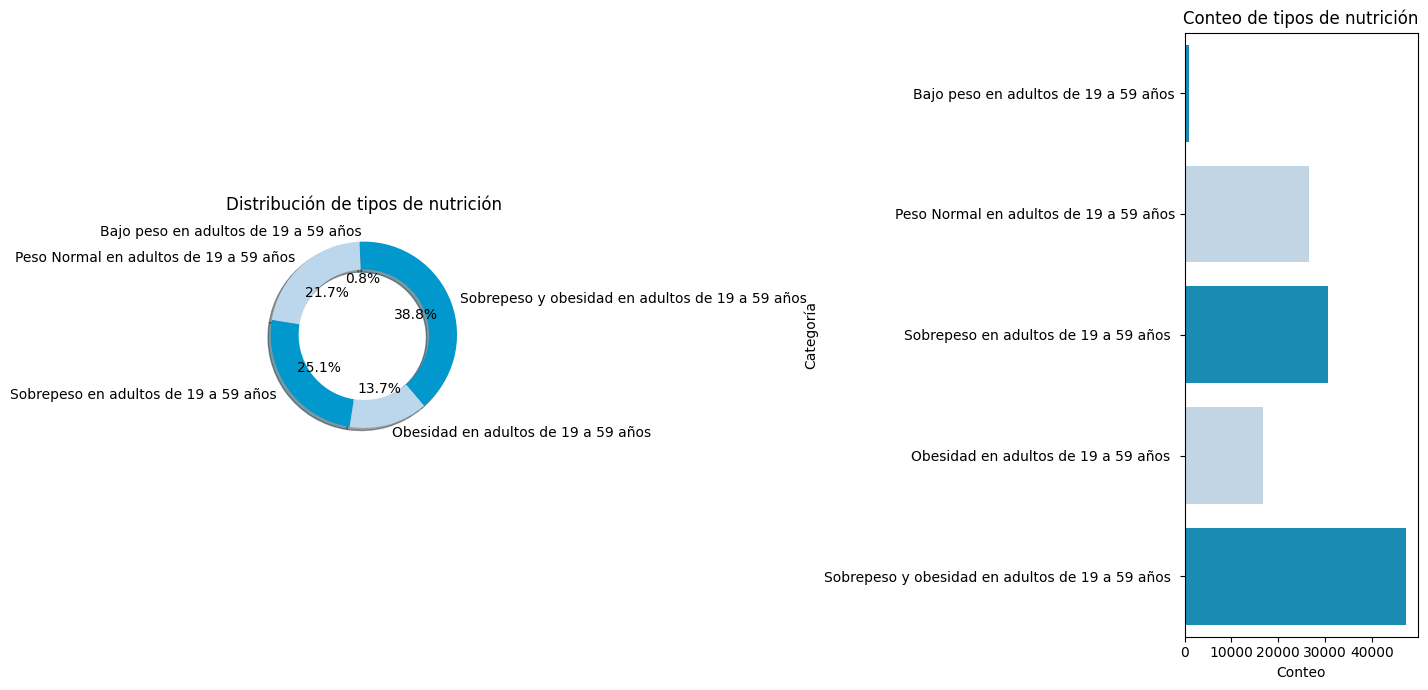

In [ ]:

totals = {
    'Bajo peso en adultos de 19 a 59 años': df['Bajo peso en adultos de 19 a 59 años'].sum(),
    'Peso Normal en adultos de 19 a 59 años': df['Peso Normal en adultos de 19 a 59 años'].sum(),
    'Sobrepeso en adultos de 19 a 59 años ': df['Sobrepeso en adultos de 19 a 59 años '].sum(),
    'Obesidad en adultos de 19 a 59 años ': df['Obesidad en adultos de 19 a 59 años '].sum(),
    'Sobrepeso y obesidad en adultos de 19 a 59 años ': df['Sobrepeso y obesidad en adultos de 19 a 59 años '].sum()
}

totals_df = pd.DataFrame(list(totals.items()), columns=['Category', 'Count'])

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
colors = ['#0098cd', '#bcd6eb']
plt.pie(totals_df['Count'], labels=totals_df['Category'], autopct='%1.1f%%', colors=colors, shadow=True, startangle=90, wedgeprops=dict(width=0.3))
#totals_df.set_index('Category').plot.pie(y='Count', autopct='%1.1f%%', colors=colors, shadow=True, startangle=90, wedgeprops=dict(width=0.3))
plt.title("Distribución de tipos de nutrición")


plt.subplot(1, 2, 2)
colors = ['#0098cd', '#bcd6eb']
sns.barplot(x='Count', y='Category', data=totals_df, palette=colors, hue='Category', dodge=False, legend=False)
plt.title("Conteo de tipos de nutrición")
plt.xlabel('Conteo')
plt.ylabel('Categoría')

# Adjust layout
plt.tight_layout()
plt.show()


### **Creación de columna Ingreso Neto**

In [ ]:
df.shape

(75257, 264)

In [ ]:
## Se creará una columna de Ingreso Neto, que integrará todas las ganancias que percibe la persona, menos los gastos que tuvo.
## Para esto, inicialmente se deben procesar los valores números de las columnas que serán utilizadas en este paso.

#*****MONTO1 CREO QUE DEBE IR COMO UN GASTO O POR LO MENOS NOS SUMARLO OJOOOOOOO****

replacement_values = {
    'Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto': 0,
    'Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto': 0,
    'Monto.1': 0, #OJOOOOO COMENTARIO ARRIBA**
    'Monto.2': 0,
    'Monto.3': 0,
    'Monto.4': 0,
    'Monto.5': 0,
    'Monto.6': 0,
    'Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto': 0,
    'Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto': 0,
    'Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto':0
}

df.fillna(replacement_values, inplace=True)


## Crear una columna para el ingreso neto sumando los montos relevantes y restando los descuentos
df['Ingreso_total'] = df[['Dinero que recibió ,por la venta de los productos, bienes o servicios de su negocio o establecimiento _Monto',
                        'Dinero líquido que recibió por concepto de sueldo o salario y otros ingresos _Monto',
                        #'Monto.1',
                        'Monto.2', 'Monto.3', 'Monto.4', 'Monto.5', 'Monto.6',
                        'Cuánto recibió en el mes, por el BONO DE DESARROLLO HUMANO _Monto',
                        'Cuánto recibió en el mes por el Bono de discapacidad Joaquín Gallegos Lara _Monto']].sum(axis=1, skipna=True)

df['Ingreso_neto'] = df['Ingreso_total'] - df['Descontaron en total por las aportaciones al IESS, impuesto a la renta, comisariatos, almacenes, cooperativas, asociaciones, etc. _Monto']


In [ ]:
#df = df[df["Ingreso_neto"]>=0]
#df.shape

### **Subset por columnas**

In [ ]:
columnas_seleccionadas = [
    'Área',
    'Provincia',
    'Sexo',
    'Edad',
    'Grupo edad en años',
    'Parentesco con el jefe (a) de hogar',
    'Cuál es su Estado Civil ó Conyugal',
    'Identificación étnica',
    'Estratos',
    'Nivel de instrucción más alto que aprobó _Nivel',
    "Año de instrucción más alto que aprobó _Año",
    'Sabe leer y escribir',
    'Está afiliado o cubierto _Alt1',
    'Está afiliado o cubierto _Alt2',
    'Tiene dificultad para ver, aunque sea con lentes',
    'Tiene dificultad para oír, incluso si utiliza un audífono',
    'Tiene dificultad para caminar o subir escaleras',
    'Tiene dificultad para recordar o concentrarse',
    'Tiene dificultad para bañarse o vestirse',
    'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
    'Principalmente donde acude o acudiría para tratar sus problemas de salud',
    'Cómo calificaría el estado de salud actual ',
    'Comparando el estado de salud actual y con el de hace un año',
    'Asiste, actualmente a clases',
    'Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar ',
    'Tiempo que busca trabajo',
    'Está disponible para trabajar',
    'Cuántos trabajos tuvo, en la semana pasada',
    'Qué hizo la semana pasada',
    'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.',
    'Recibe el Bono de desarrollo humano',
    'En el lugar indicado, trabaja o trabajó como',
    'Ingreso_neto',
    'Tuvo algún parto  _últimos 12 meses ',
    'Peso',
    'Talla',
    'Bajo peso en adultos de 19 a 59 años',
    'Peso Normal en adultos de 19 a 59 años',
    'Sobrepeso en adultos de 19 a 59 años ',
    'Obesidad en adultos de 19 a 59 años ',
    ]


In [ ]:
df = df[columnas_seleccionadas]

In [ ]:
# Cantidad de columnas despues del filtrado
len(df.columns)

40

In [ ]:
cols_del =[]

for i in df_original.columns:
  if i not in df.columns:
    cols_del.append(i)

In [ ]:
df.head(5)

Área  Provincia    Sexo  Edad Grupo edad en años Parentesco con el jefe (a) de hogar Cuál es su Estado Civil ó Conyugal Identificación étnica  Estratos Nivel de instrucción más alto que aprobó _Nivel  Año de instrucción más alto que aprobó _Año Sabe leer y escribir Está afiliado o cubierto _Alt1 Está afiliado o cubierto _Alt2 Tiene dificultad para ver, aunque sea con lentes Tiene dificultad para oír, incluso si utiliza un audífono Tiene dificultad para caminar o subir escaleras Tiene dificultad para recordar o concentrarse Tiene dificultad para bañarse o vestirse Tiene dificultad para comunicarse es decir comprender o ser comprendido Principalmente donde acude o acudiría para tratar sus problemas de salud Cómo calificaría el estado de salud actual  Comparando el estado de salud actual y con el de hace un año Asiste, actualmente a clases Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar   Tiempo que busca trabajo Está disponible para trabajar Cuántos trabajos tuvo, en la semana pasada   Qué hizo la semana pasada Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc. Recibe el Bono de desarrollo humano En el lugar indicado, trabaja o trabajó como  Ingreso_neto Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años 
0   urbano          1  hombre    28              20-49                     jefe/a de hogar                        unión libre               Mestizo      2713                                        primaria                                          6.0                   si          iess, seguro general?                       ninguno?                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                         medicina general(convencional)?                                                            bueno?                                             igual?                                     no                                                NaN                                                                                NaN                           NaN                                        uno  trabajó al menos una hora?                                                 no                                                                                                          no               empleado(a)/obrero(a) privado?         440.0                                  NaN   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0
6   urbano          1   mujer    36              20-49                     jefe/a de hogar                        unión libre               Mestizo      2713                                      secundaria                                          5.0                  NaN                       ninguno?                       ninguno?                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                         medicina general(convencional)?                                                            bueno?                                             igual?                                     no                                                NaN                                                       

In [ ]:
df.shape

(75257, 40)

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


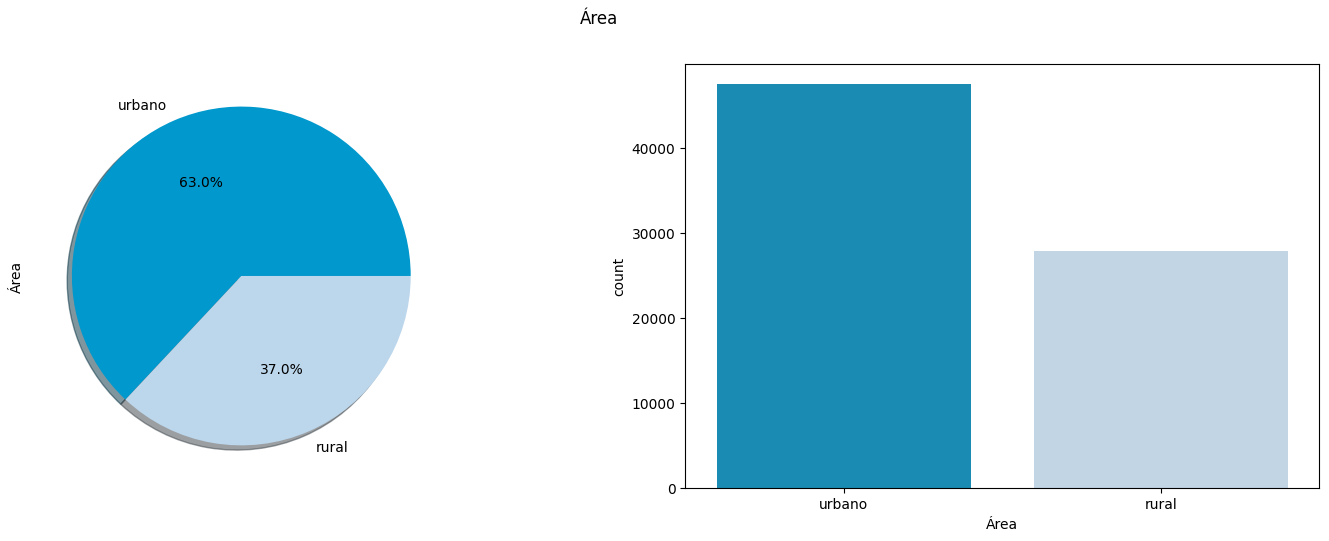

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


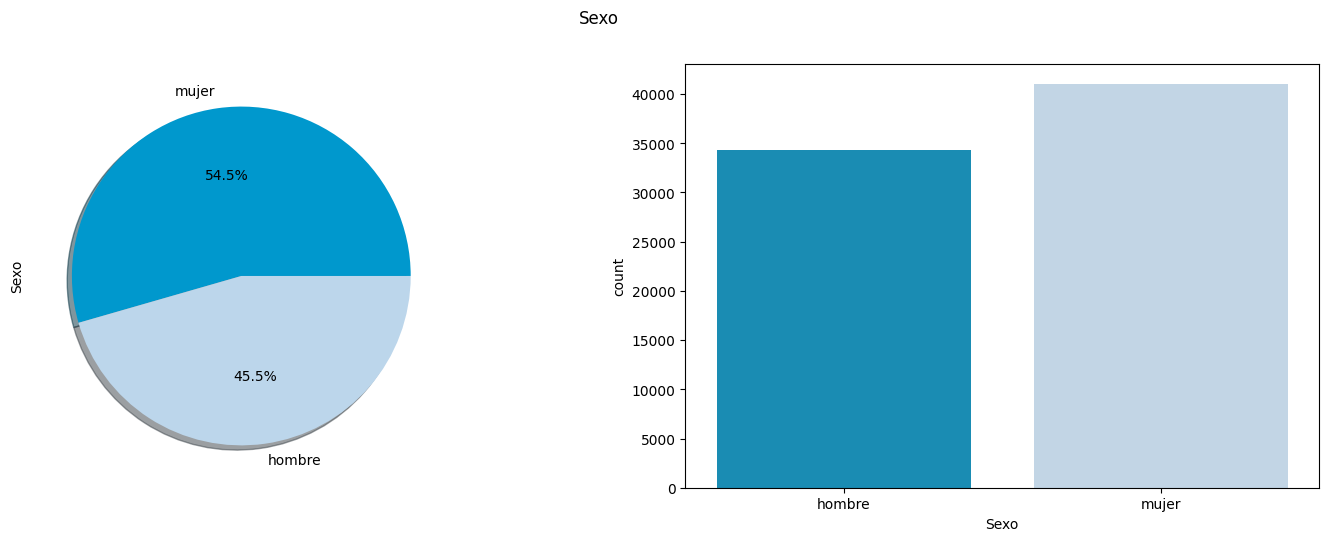

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


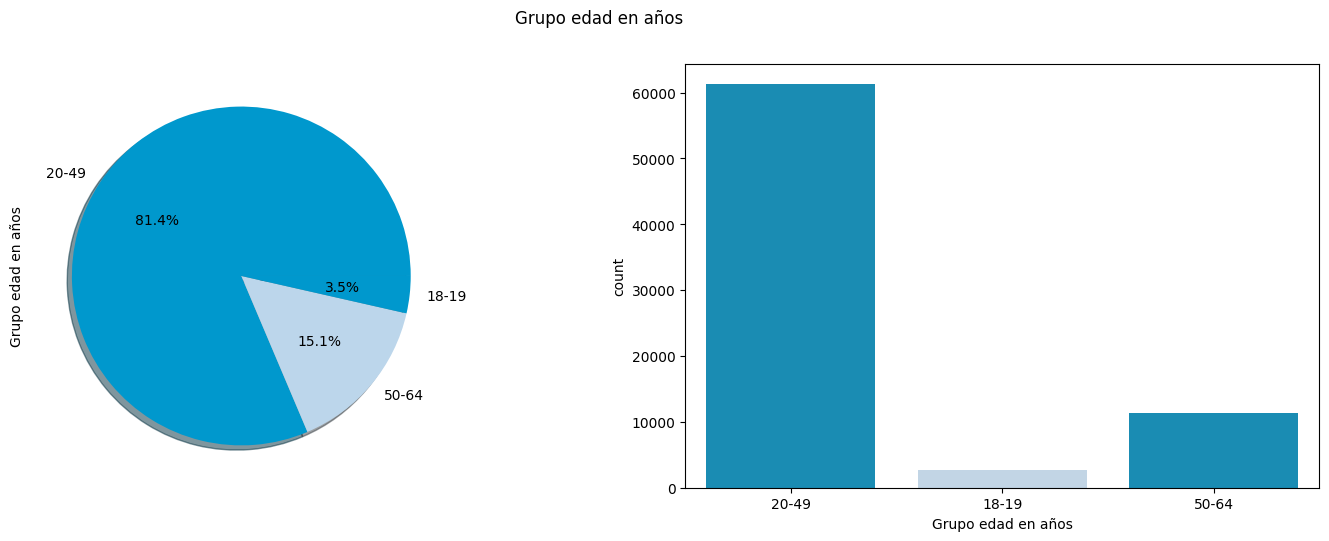

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


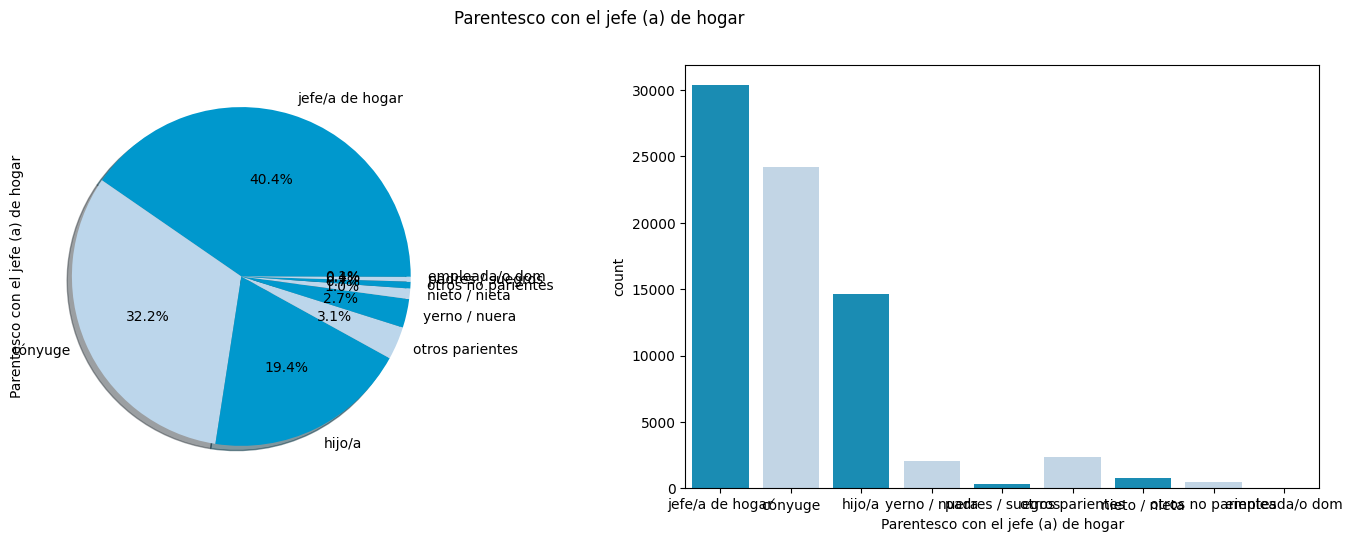

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


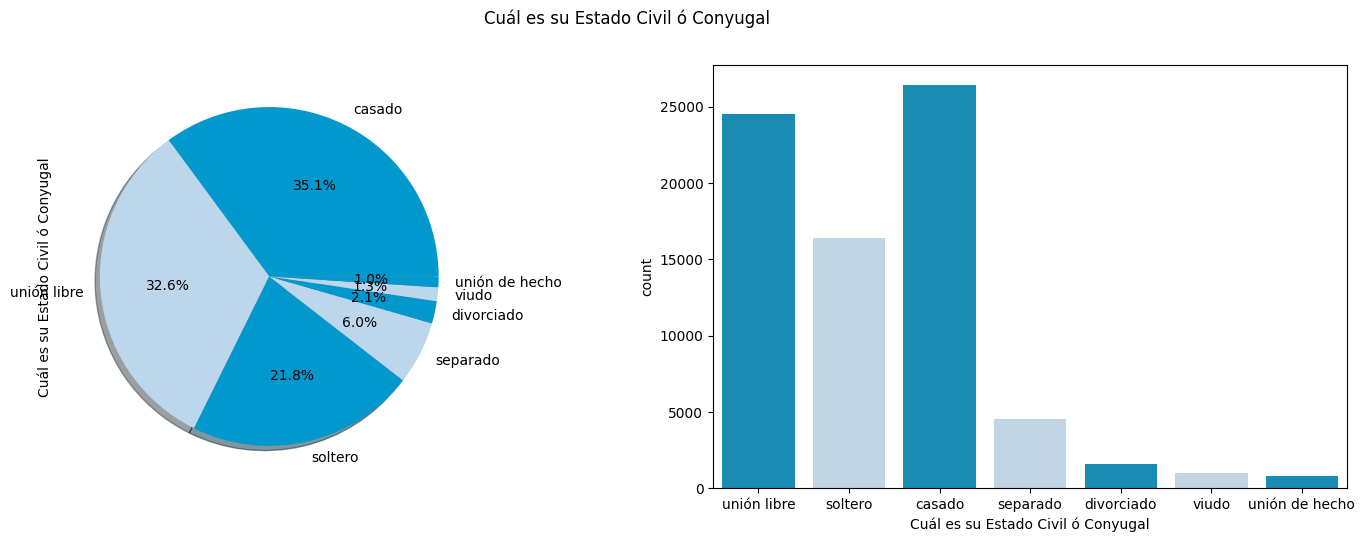

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


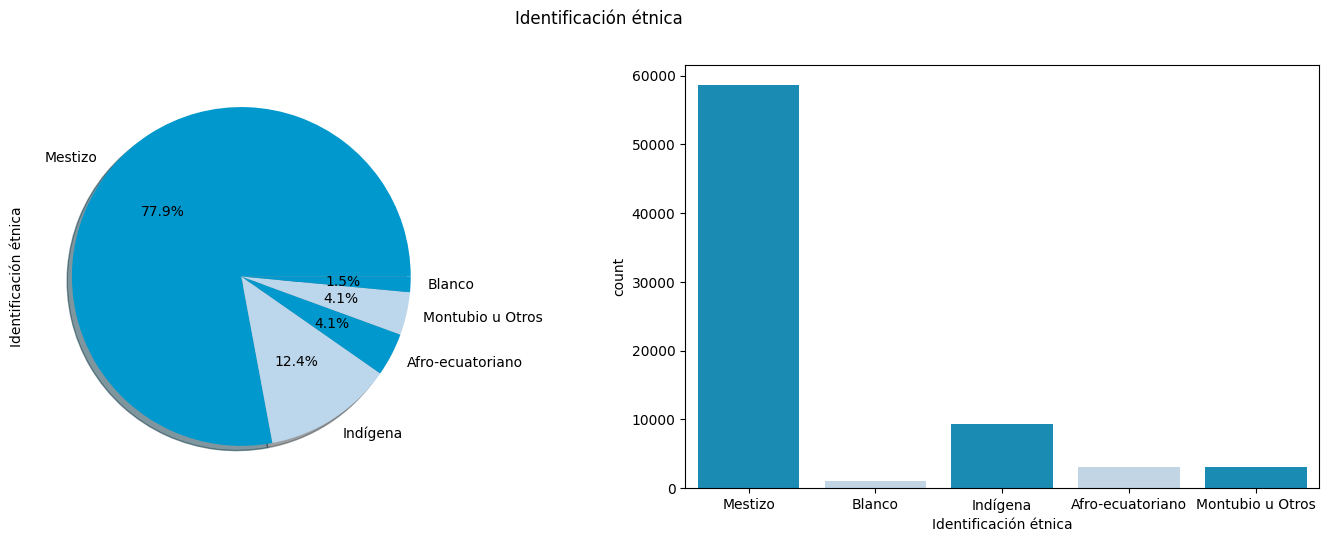

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


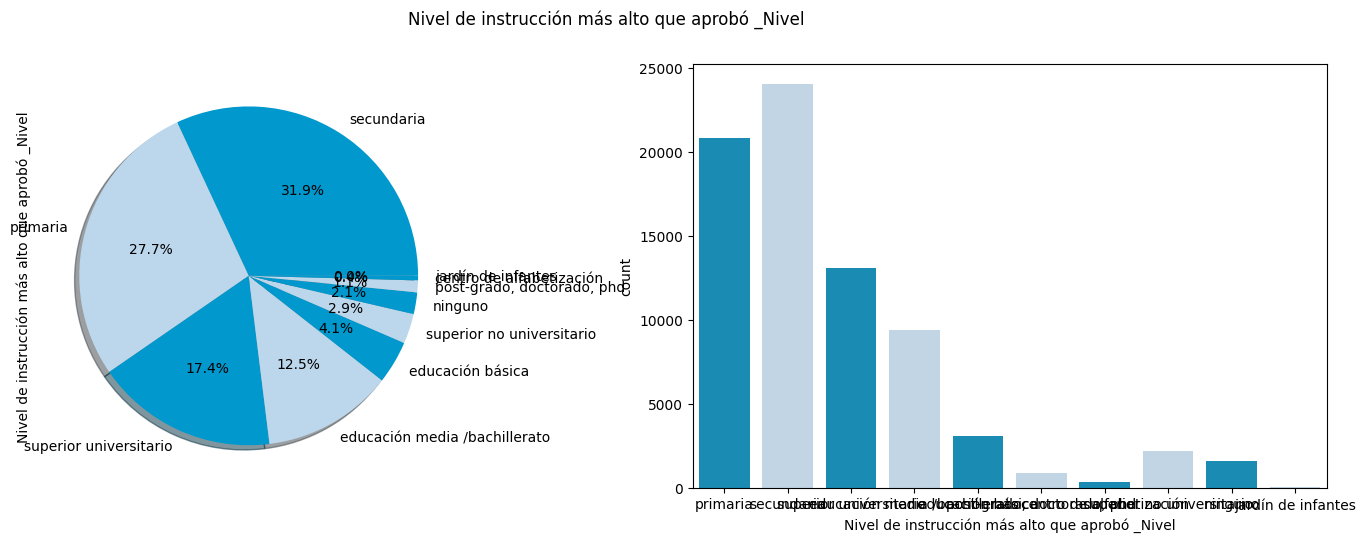

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


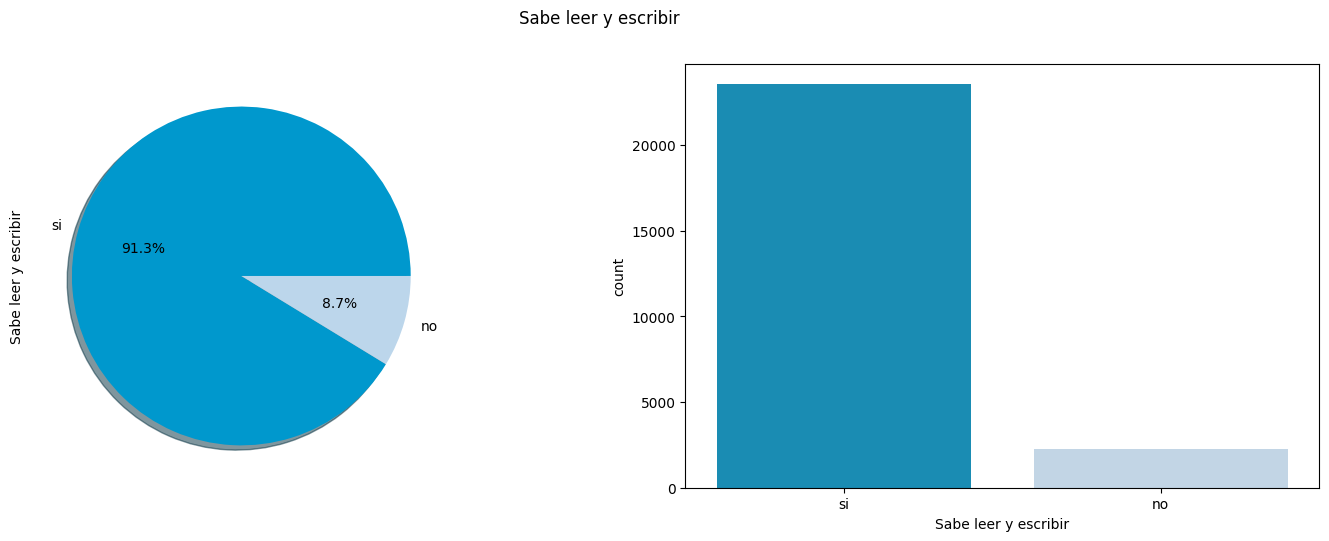

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


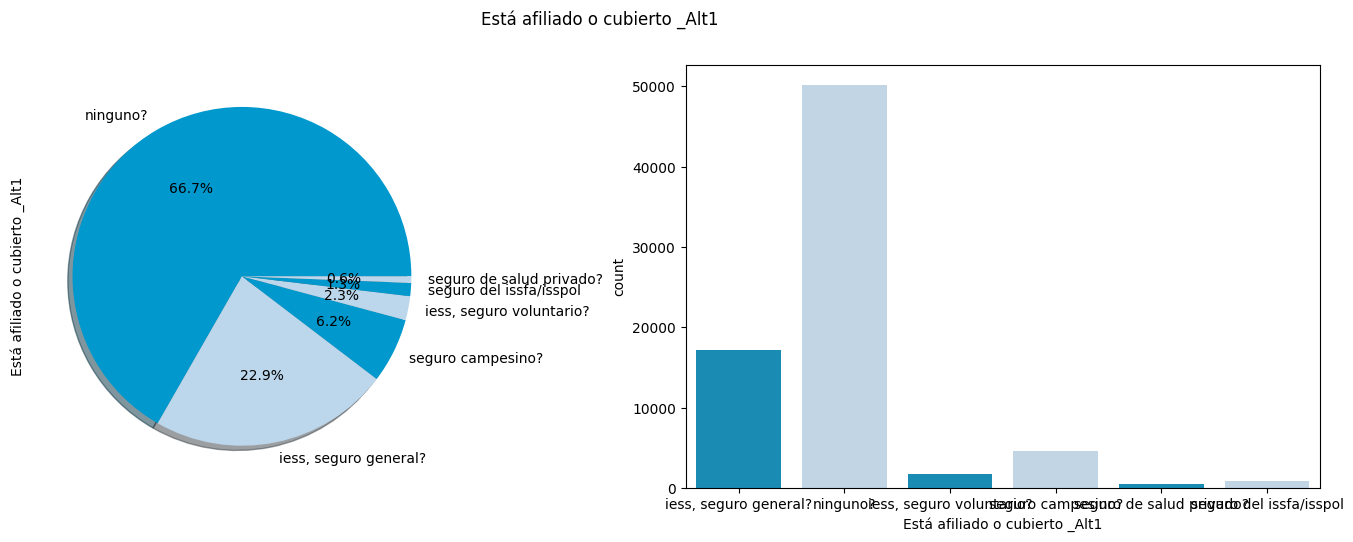

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


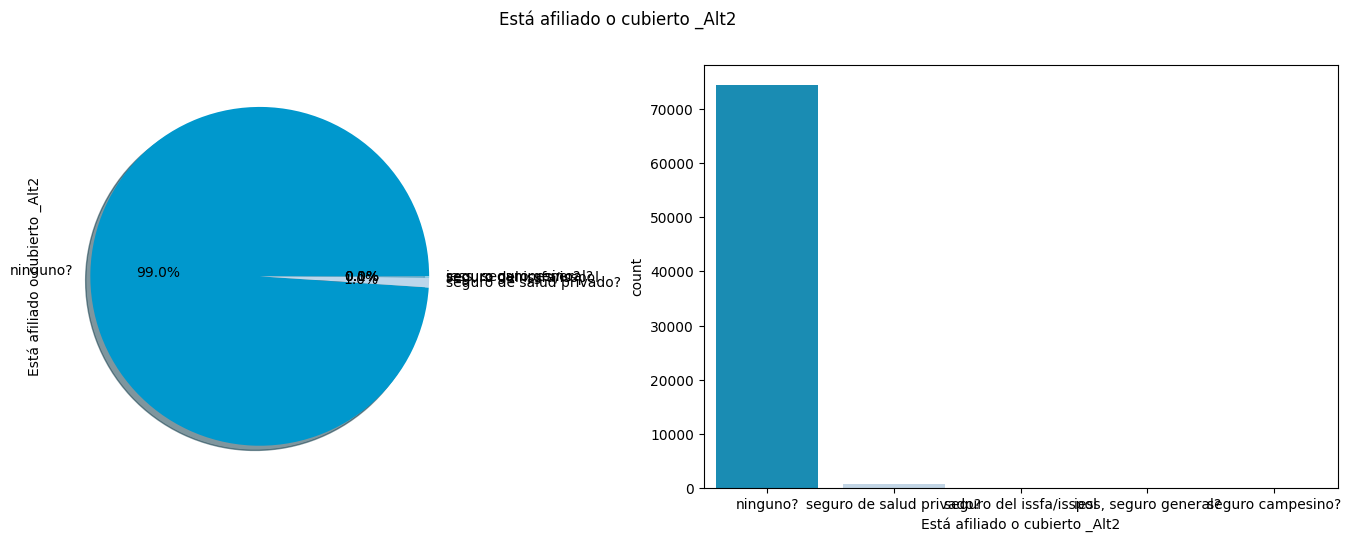

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


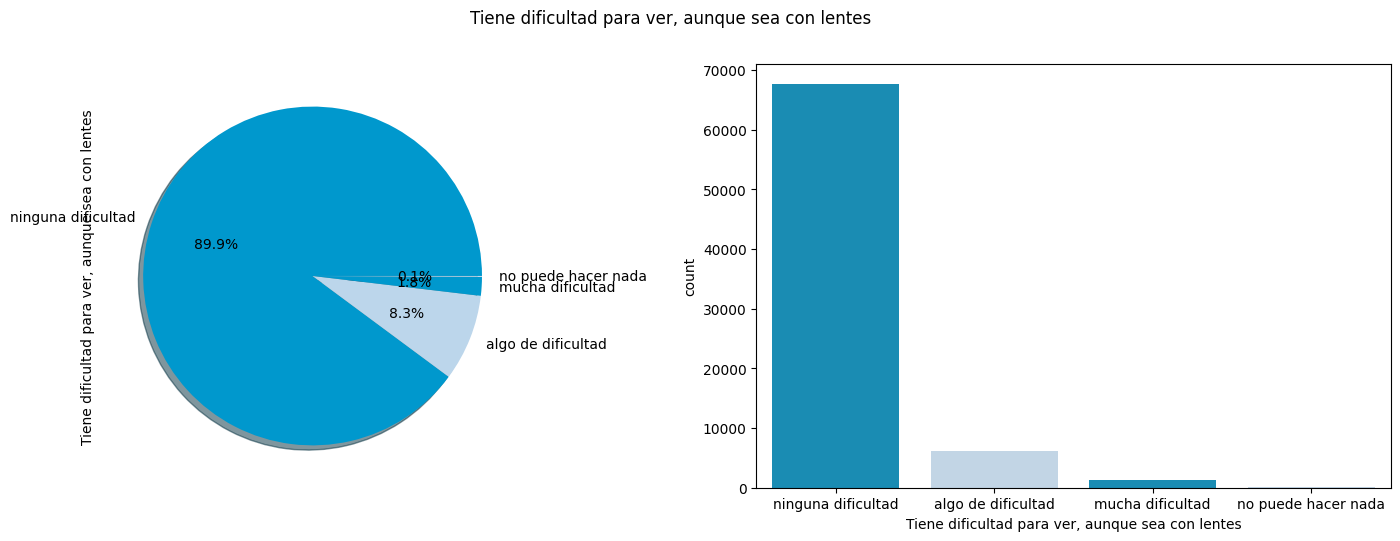

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


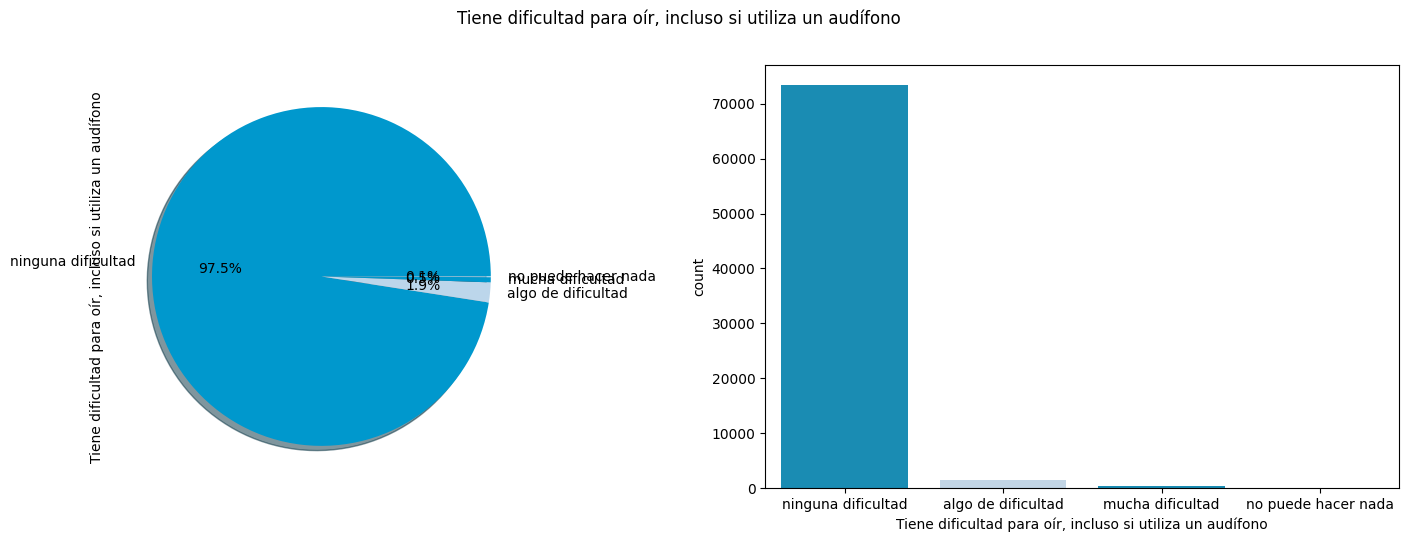

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


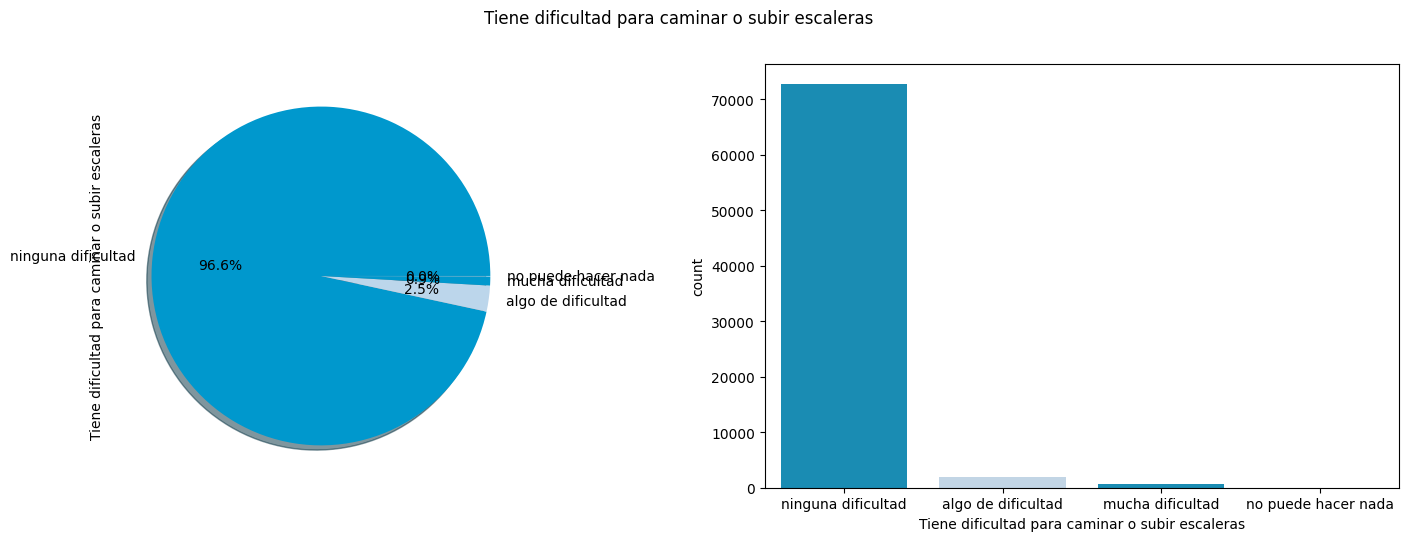

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


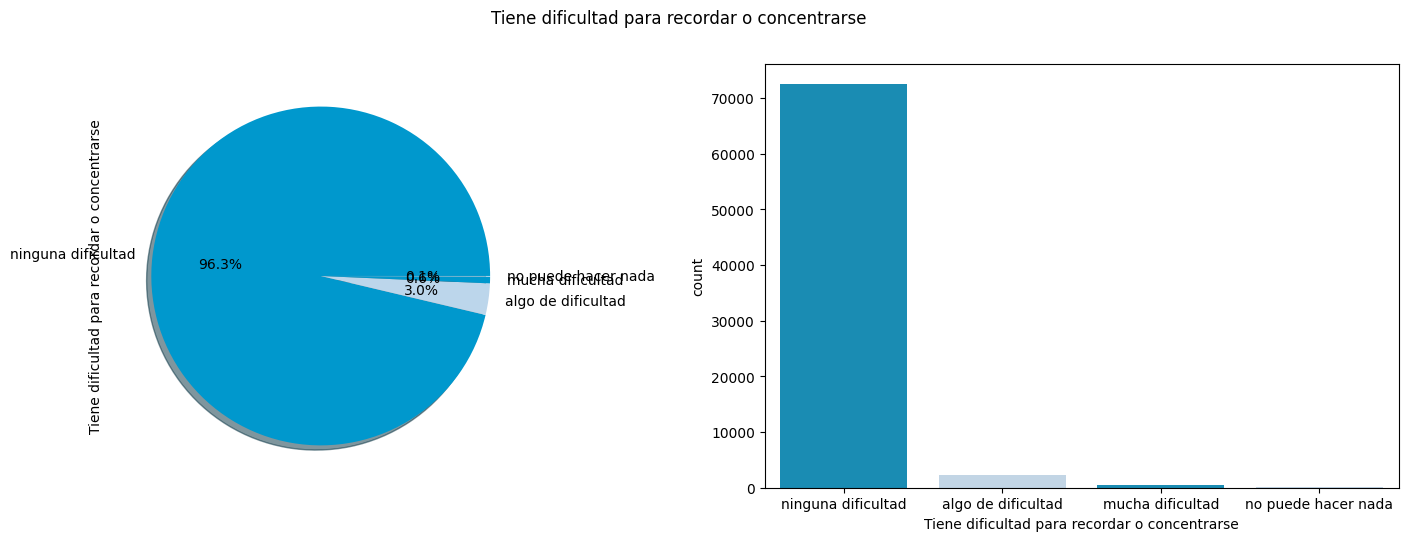

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


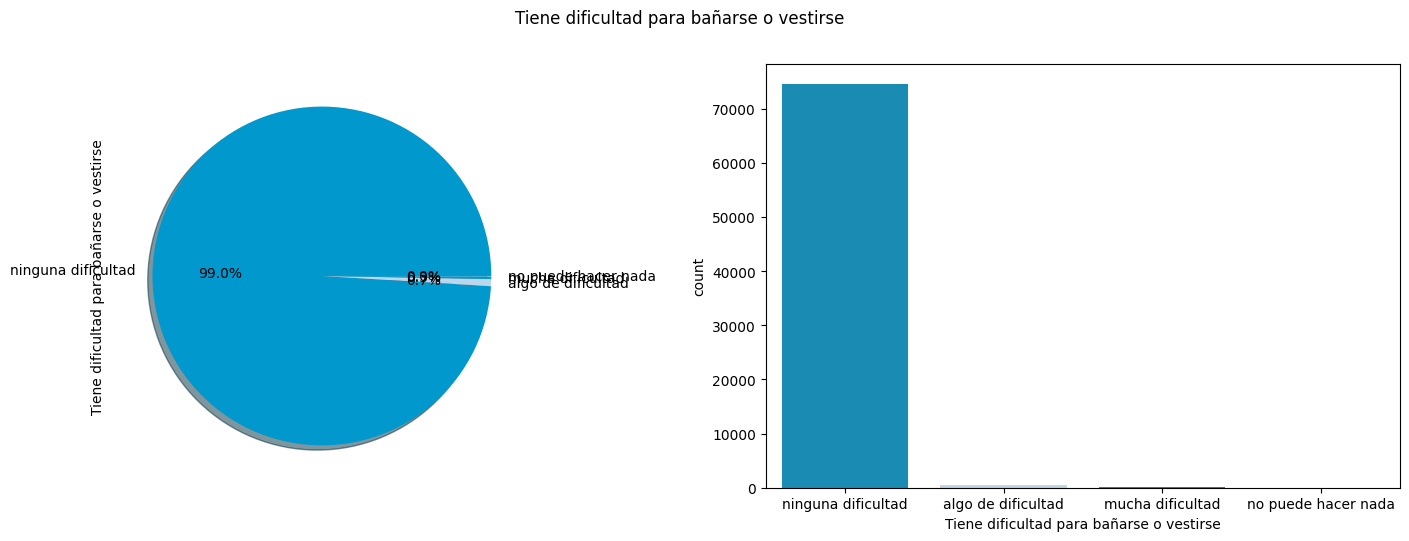

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


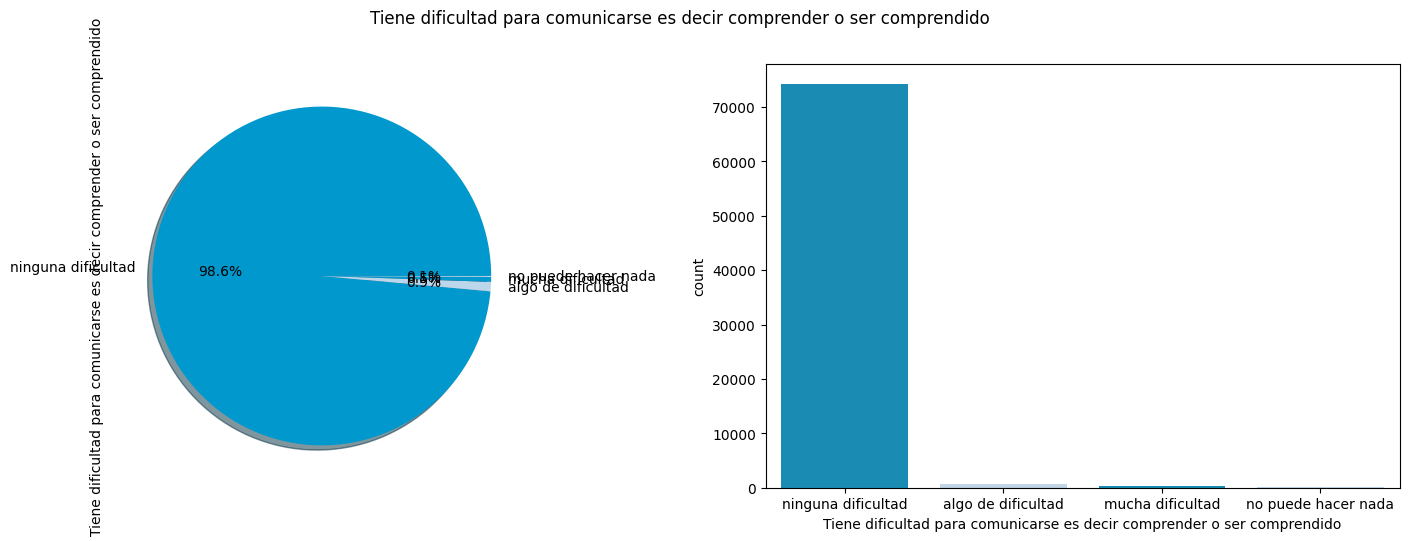

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


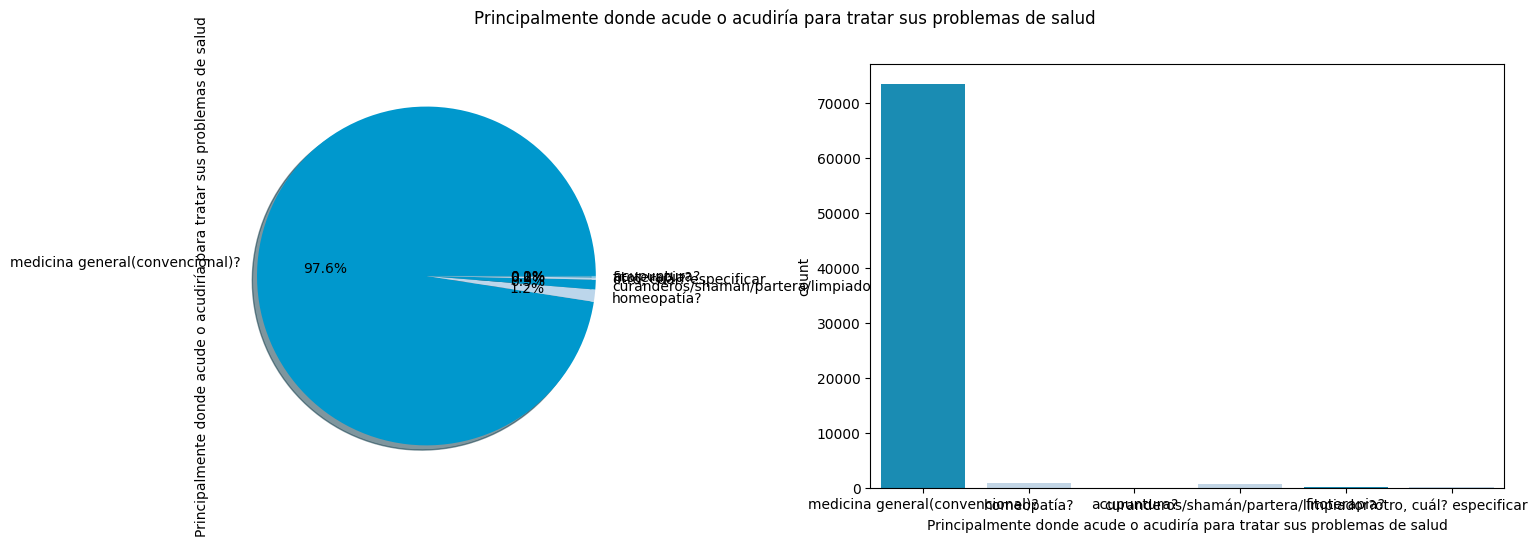

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


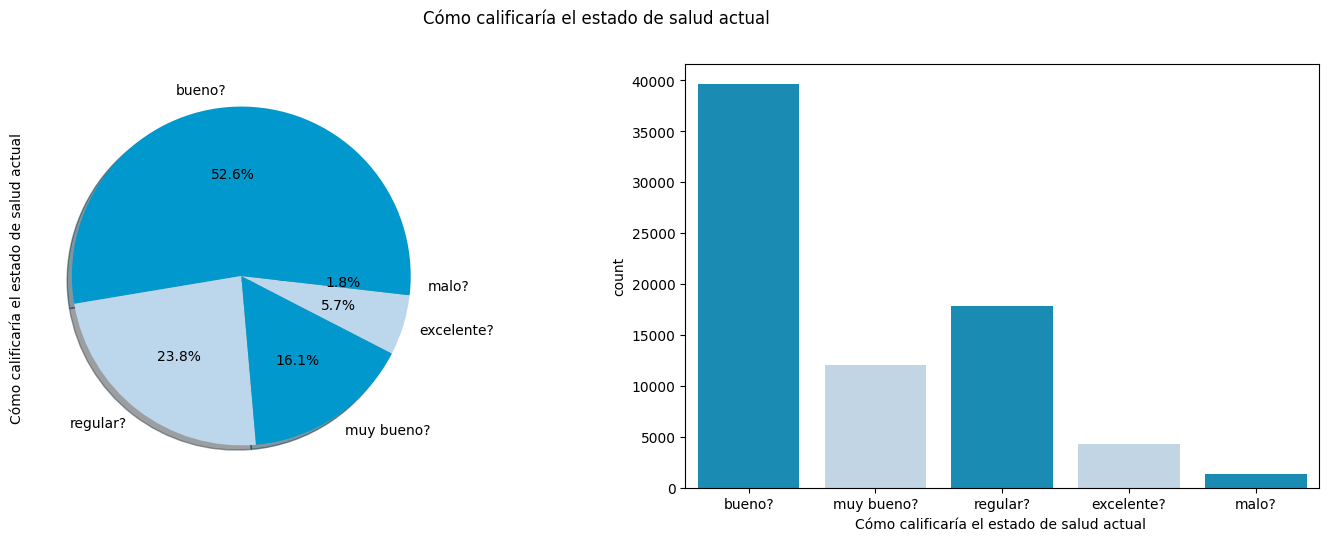

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


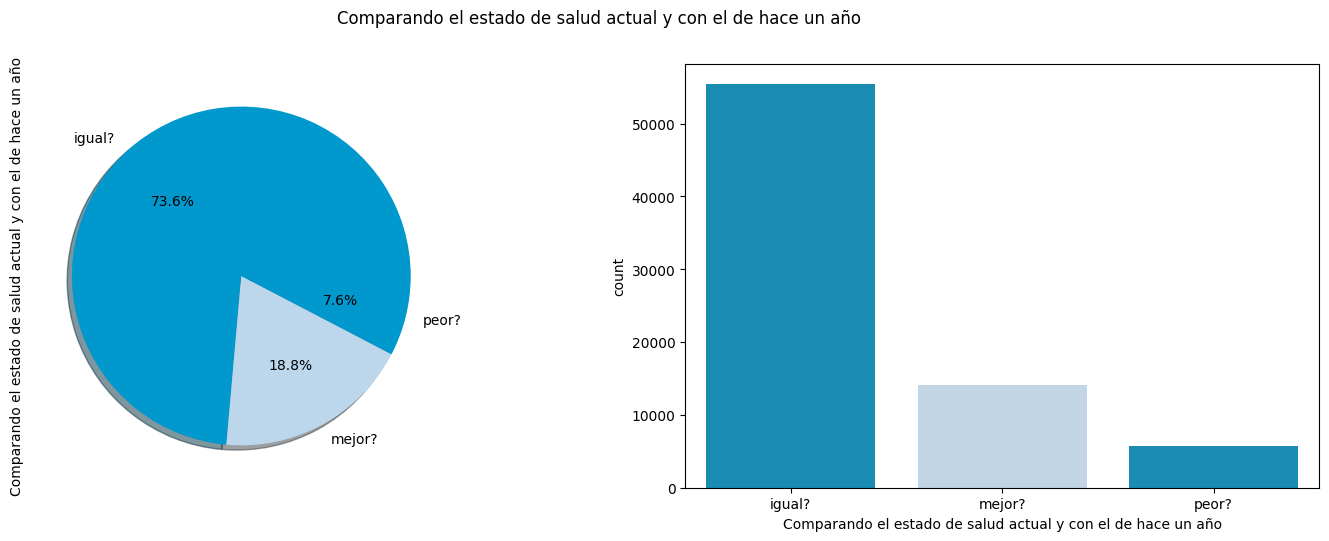

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


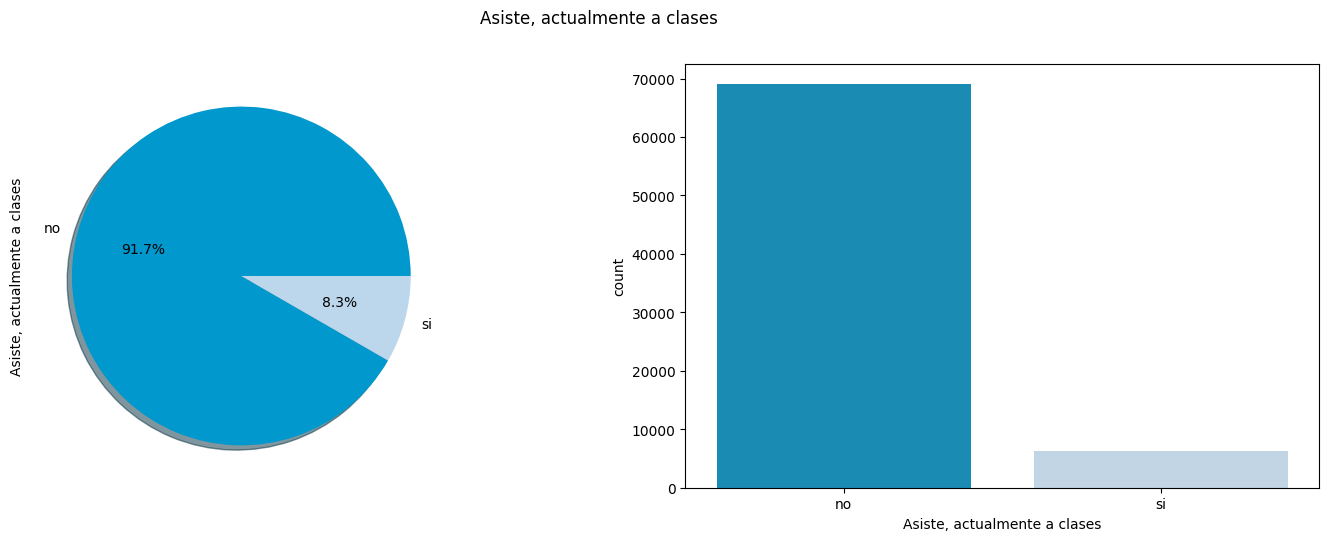

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


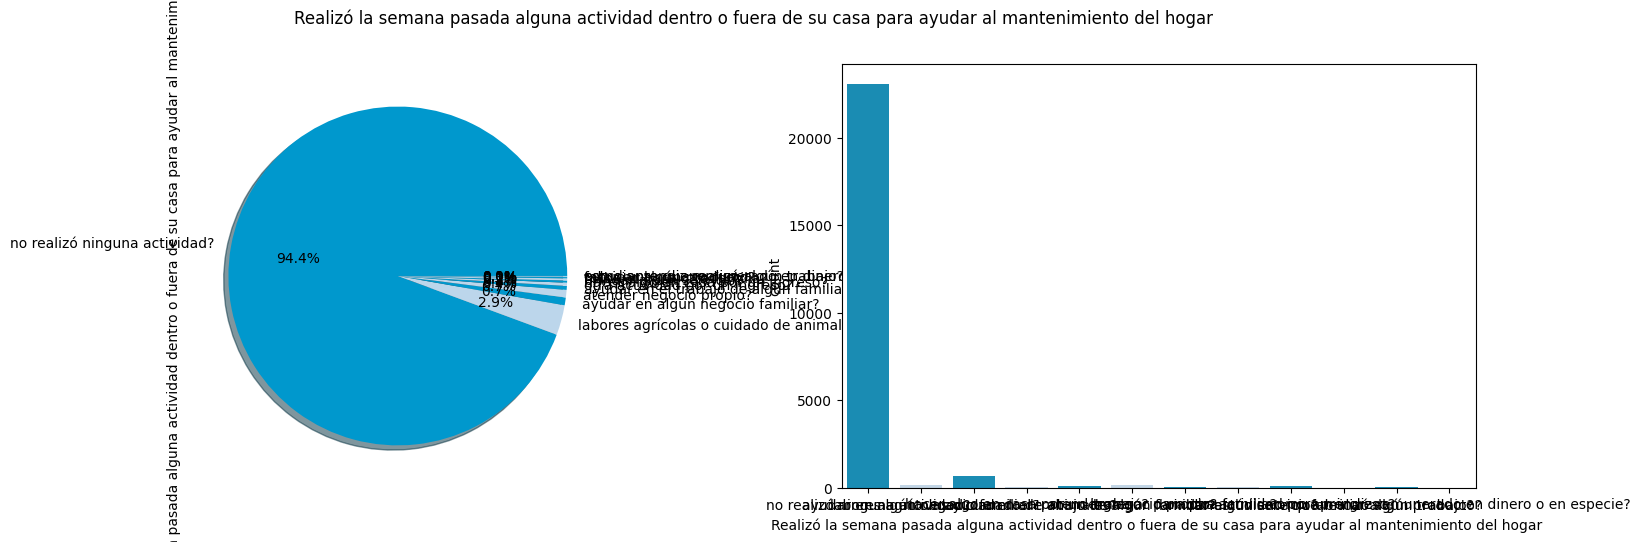

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


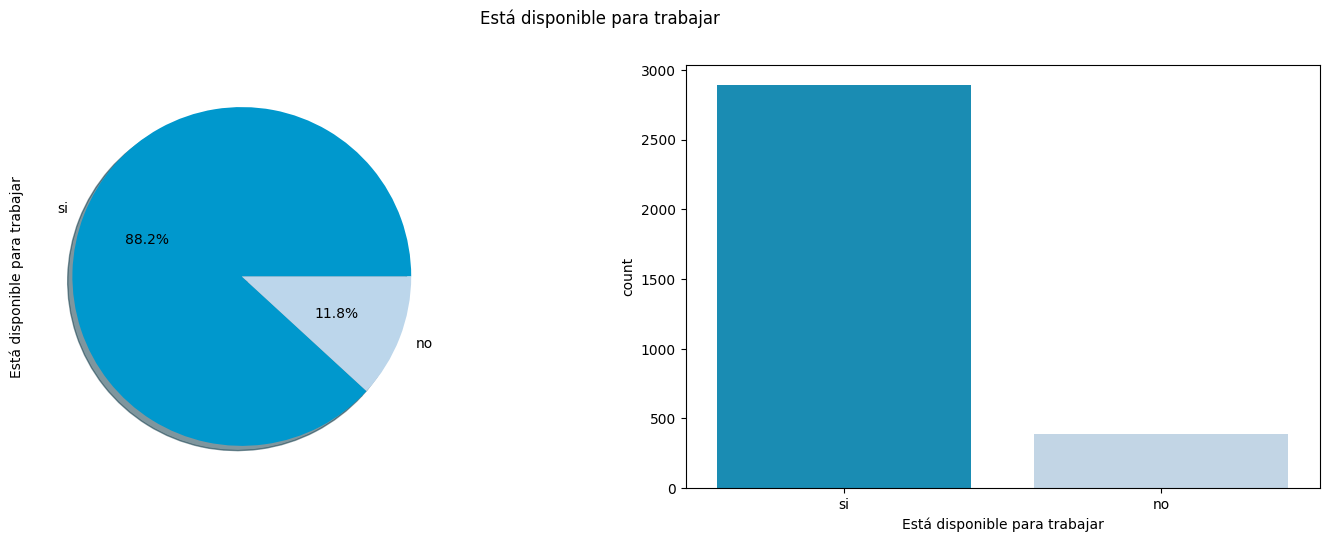

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


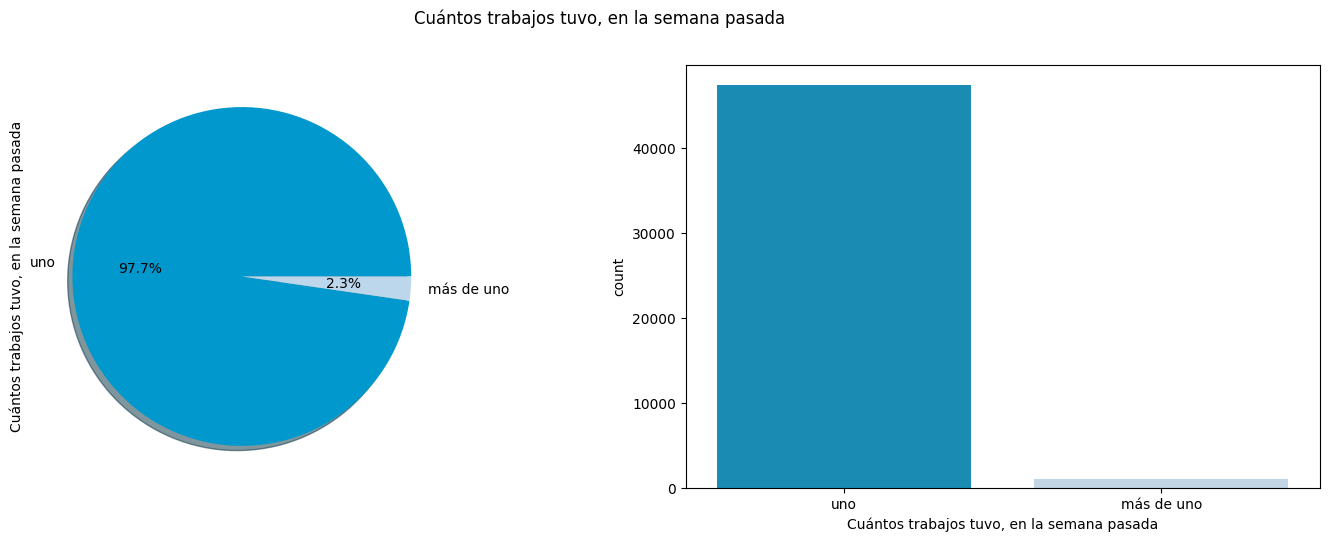

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


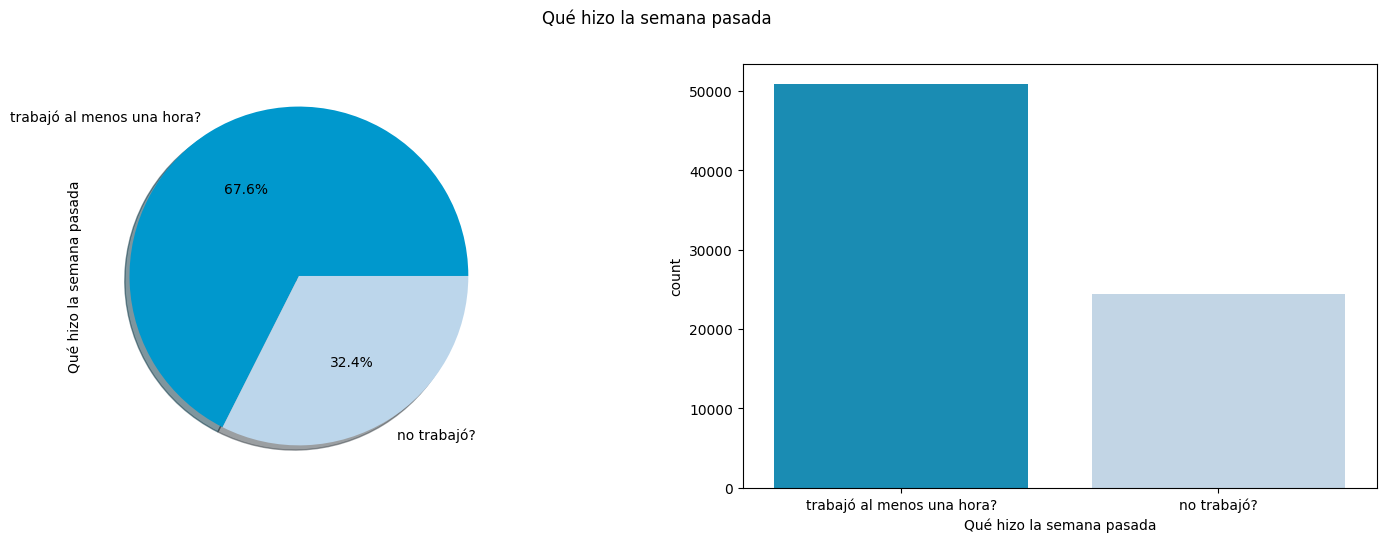

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


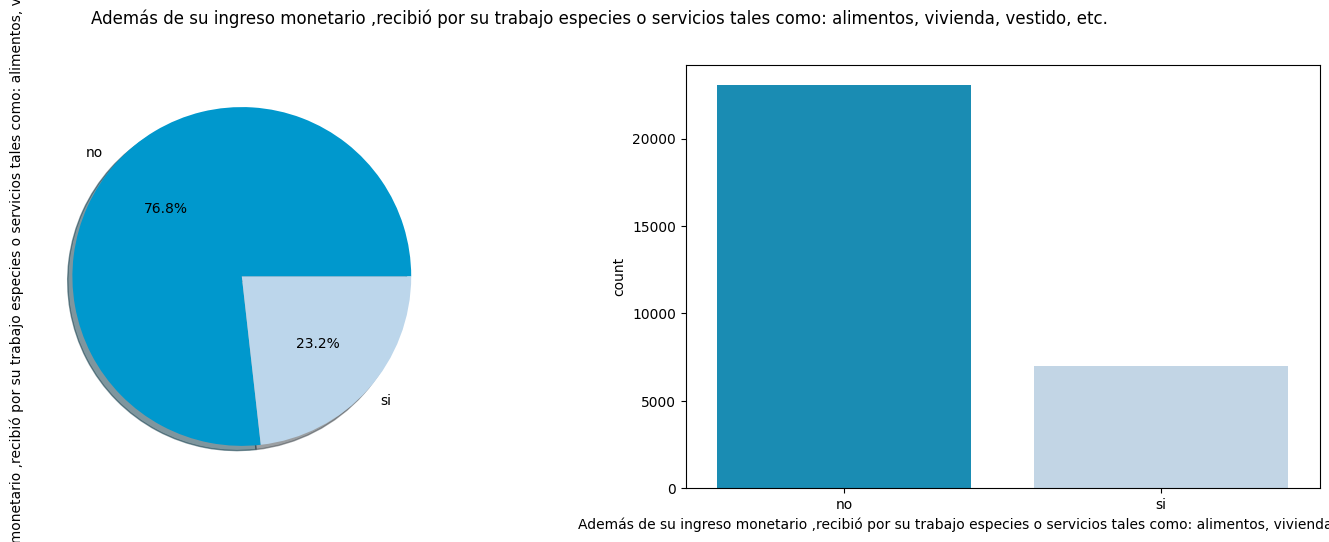

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


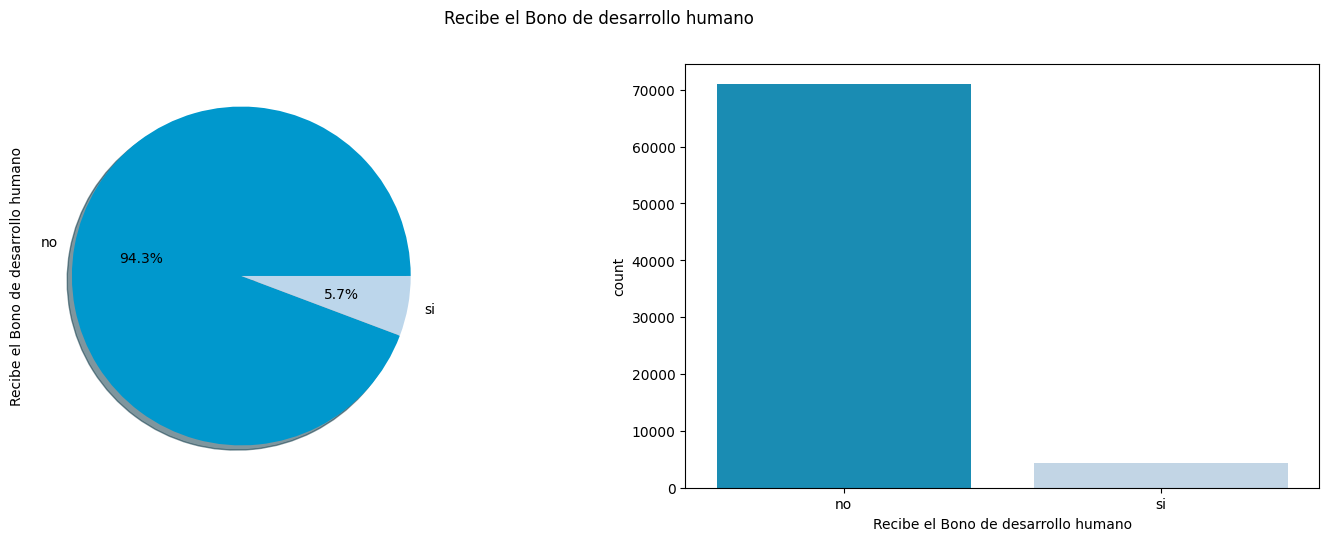

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
<ipython-input-212-b04112ca29fa>:9: UserWarning: 
The palette list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


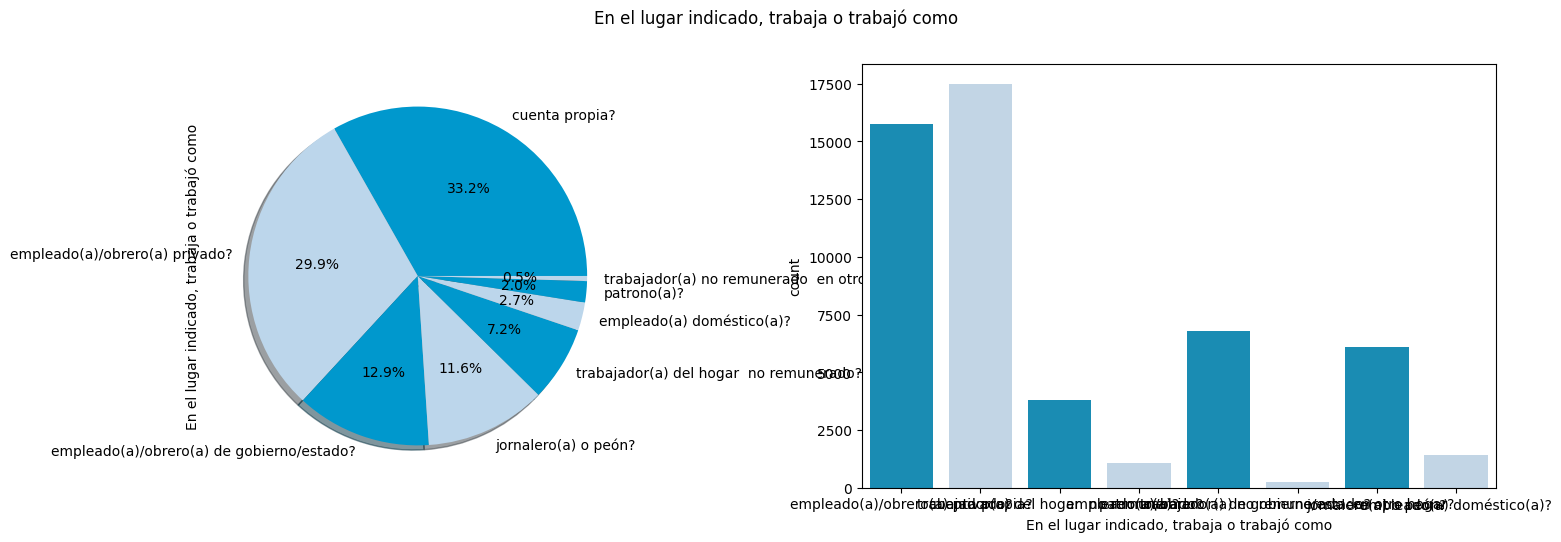

<ipython-input-212-b04112ca29fa>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = column, data = df,ax=ax[1], palette=colors)


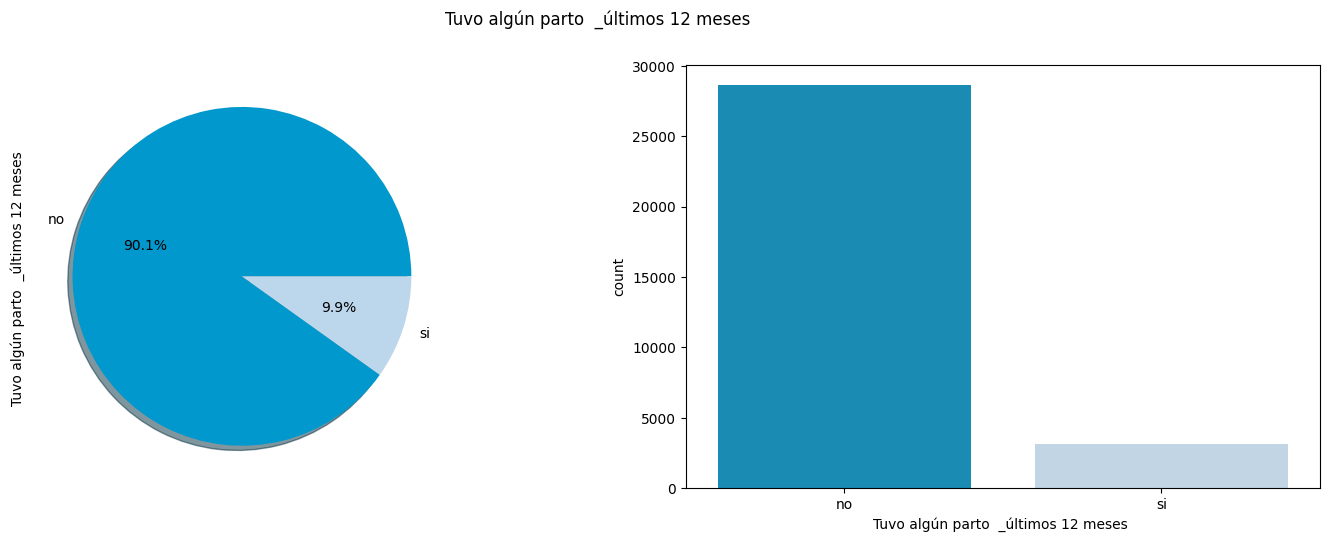

In [ ]:
# Obtener todas las columnas categóricas excepto 'NObeyesdad'
categorical_vars = [column for column in df.columns if column != 'NObeyesdad' and df[column].dtype == 'object']
# Especificar los colores deseados
colors = ['#0098cd', '#bcd6eb']
for column in categorical_vars:
    f,ax = plt.subplots(1,2,figsize = (18,5.5))
    df[column].value_counts().plot.pie(autopct = '%1.1f%%',ax = ax[0],shadow = True, colors=colors)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x = column, data = df,ax=ax[1], palette=colors)
    plt.suptitle(f'{column}')
    plt.show()

### **Imputación de Nulos**

In [ ]:
#Porcentaje de valores nulos en cada columna
df.isnull().mean().round(4)*100

Área                                                                                                                           0.00
Provincia                                                                                                                      0.00
Sexo                                                                                                                           0.00
Edad                                                                                                                           0.00
Grupo edad en años                                                                                                             0.00
Parentesco con el jefe (a) de hogar                                                                                            0.00
Cuál es su Estado Civil ó Conyugal                                                                                             0.00
Identificación étnica                                                       

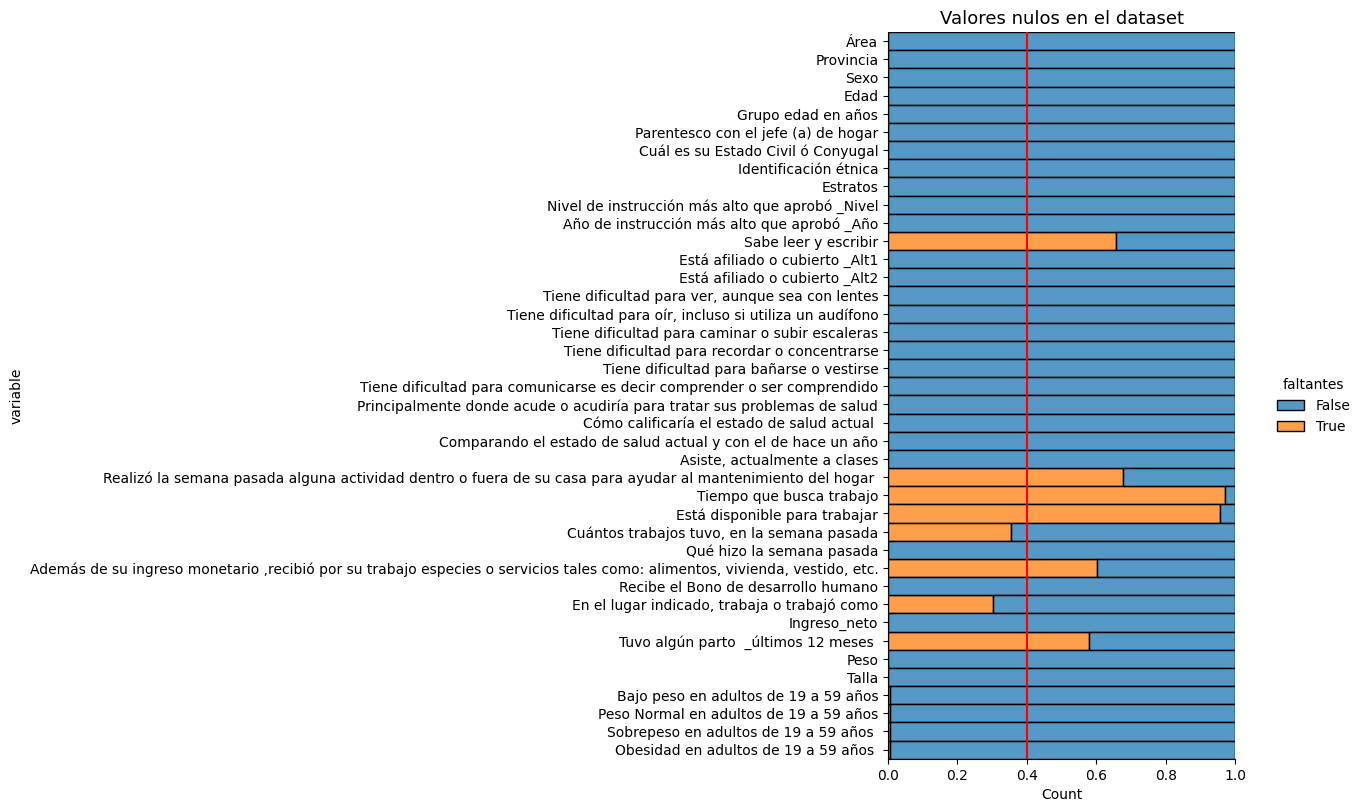

In [ ]:
sns.displot(data=df.isnull().melt(value_name = 'faltantes'),
           y = 'variable',
           hue = 'faltantes',multiple='fill',height=8,aspect = 1.6)
plt.axvline(0.4,color = 'r')
plt.title("Valores nulos en el dataset",fontsize = 13)
plt.show()

In [ ]:
# List of columns to drop
columns_to_drop = ['Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar ', 'Está disponible para trabajar','Tiempo que busca trabajo']

# Drop the columns
df = df.drop(columns=columns_to_drop)

In [ ]:
# df['Tiempo que busca trabajo'] = df['Tiempo que busca trabajo'].fillna(0)

# df['Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar '] = df['Realizó la semana pasada alguna actividad dentro o fuera de su casa para ayudar al mantenimiento del hogar '].fillna("no realizó ninguna actividad")

# df['Está disponible para trabajar'] = df['Está disponible para trabajar'].fillna("no")

df['Cuántos trabajos tuvo, en la semana pasada'] = df['Cuántos trabajos tuvo, en la semana pasada'].fillna("cero")

df['Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.'] = df['Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.'].fillna("no")

df['Recibe el Bono de desarrollo humano'] = df['Recibe el Bono de desarrollo humano'].fillna("no")

df['En el lugar indicado, trabaja o trabajó como'] = df['En el lugar indicado, trabaja o trabajó como'].fillna("no trabaja")

df['Tuvo algún parto  _últimos 12 meses '] = df['Tuvo algún parto  _últimos 12 meses '].fillna("no")

df["Sabe leer y escribir"] = df["Sabe leer y escribir"].fillna("si")



In [ ]:
df.shape

(75257, 37)

In [ ]:
df=df.dropna(subset=['Bajo peso en adultos de 19 a 59 años',
    'Peso Normal en adultos de 19 a 59 años',
    'Sobrepeso en adultos de 19 a 59 años ',
    'Obesidad en adultos de 19 a 59 años '])

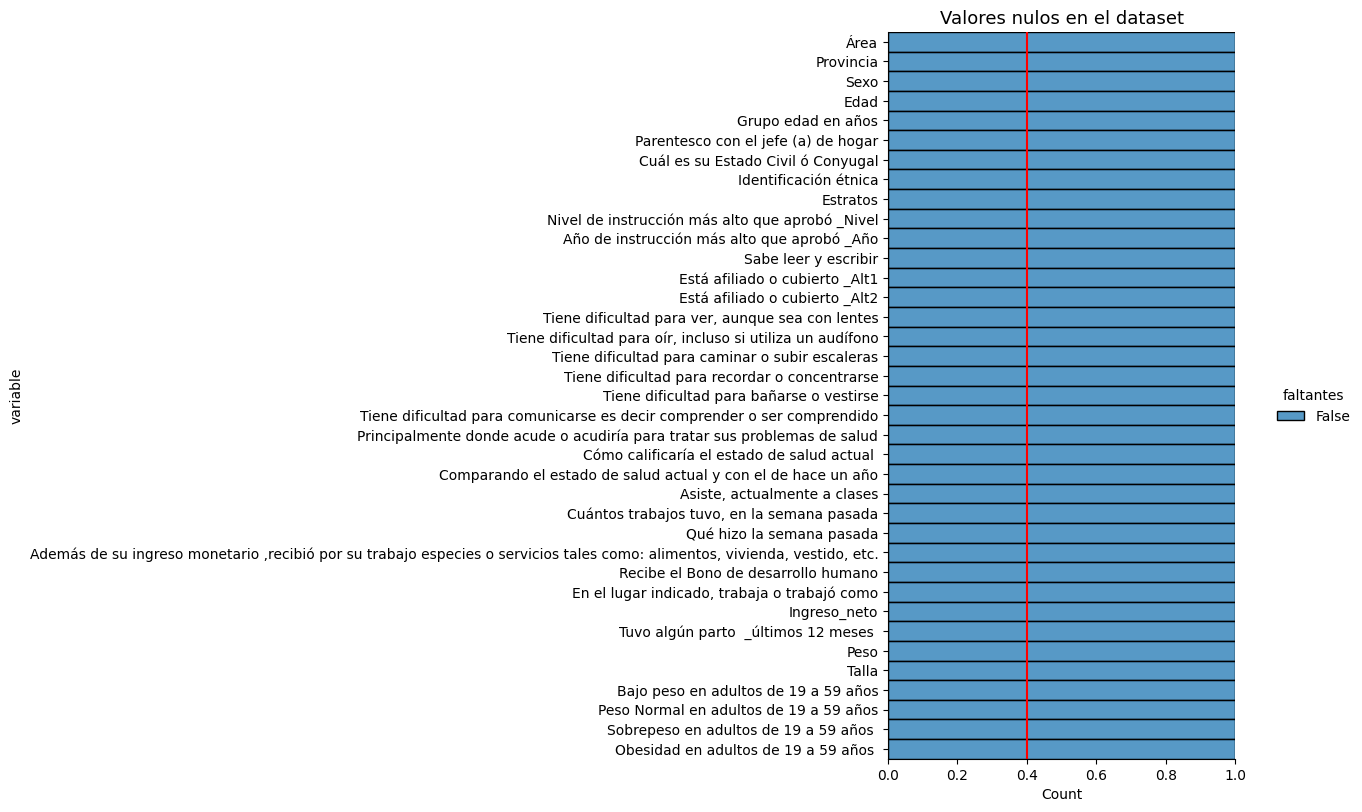

In [ ]:
sns.displot(data=df.isnull().melt(value_name = 'faltantes'),
           y = 'variable',
           hue = 'faltantes',multiple='fill',height=8,aspect = 1.6)
plt.axvline(0.4,color = 'r')
plt.title("Valores nulos en el dataset",fontsize = 13)
plt.show()

In [ ]:
df.isna().sum()

Área                                                                                                                          0
Provincia                                                                                                                     0
Sexo                                                                                                                          0
Edad                                                                                                                          0
Grupo edad en años                                                                                                            0
Parentesco con el jefe (a) de hogar                                                                                           0
Cuál es su Estado Civil ó Conyugal                                                                                            0
Identificación étnica                                                                                   

### **Eliminación de signo (?)**

In [ ]:
df = df.replace('\?', '', regex=True)

### **Union de columnas de afiliacion y transformacion en numerica (para reducir dimensionalidad)**

In [ ]:
#para hacer una sola columna numerica sobre la afiliacion
# Reemplazar valores en las columnas
df['Está afiliado o cubierto _Alt1'] = df['Está afiliado o cubierto _Alt1'].apply(lambda x: 0 if 'ninguno' in x.lower() else 1)
df['Está afiliado o cubierto _Alt2'] = df['Está afiliado o cubierto _Alt2'].apply(lambda x: 0 if 'ninguno' in x.lower() else 1)

# Crear la nueva columna sumando las dos anteriores
df['num_afiliaciones'] = df['Está afiliado o cubierto _Alt1'] + df['Está afiliado o cubierto _Alt2']

df.drop(columns=['Está afiliado o cubierto _Alt1', 'Está afiliado o cubierto _Alt2'], inplace=True)

In [ ]:
df["num_afiliaciones"].value_counts()

num_afiliaciones
0    49837
1    24163
2      786
Name: count, dtype: int64

### **Nueva columna de años de estudio (para reducir dimensionalidad)**

In [ ]:
# Asignar 'ninguno' a la columna de nivel de instrucción si el año de instrucción es 0
df.loc[df['Año de instrucción más alto que aprobó _Año'] == 0, 'Nivel de instrucción más alto que aprobó _Nivel'] = 'ninguno'

In [ ]:
# Aplicar la función a cada fila para crear la nueva columna
df['años_totales_estudio'] = df.apply(calcular_anios_totales, axis=1)

# Mostrar las primeras filas para verificar
df.sample(5)

Área  Provincia    Sexo  Edad Grupo edad en años Parentesco con el jefe (a) de hogar Cuál es su Estado Civil ó Conyugal Identificación étnica  Estratos Nivel de instrucción más alto que aprobó _Nivel  Año de instrucción más alto que aprobó _Año Sabe leer y escribir Tiene dificultad para ver, aunque sea con lentes Tiene dificultad para oír, incluso si utiliza un audífono Tiene dificultad para caminar o subir escaleras Tiene dificultad para recordar o concentrarse Tiene dificultad para bañarse o vestirse Tiene dificultad para comunicarse es decir comprender o ser comprendido Principalmente donde acude o acudiría para tratar sus problemas de salud Cómo calificaría el estado de salud actual  Comparando el estado de salud actual y con el de hace un año Asiste, actualmente a clases Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc. Recibe el Bono de desarrollo humano En el lugar indicado, trabaja o trabajó como  Ingreso_neto Tuvo algún parto  _últimos 12 meses        Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años   num_afiliaciones  años_totales_estudio
165764  urbano         24  hombre    53              50-64                     jefe/a de hogar                             casado               Mestizo      2411                                        primaria                                          6.0                   si                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                          medicina general(convencional)                                                           regular                                              igual                                     no                                        uno  trabajó al menos una hora                                                 no                                                                                                          no                                cuenta propia         260.0                                   no  64.199997  170.00000                                   0.0                                     1.0                                    0.0                                   0.0                 0                   6.0
158565  urbano         23   mujer    19              18-19                  otros no parientes                        unión libre               Mestizo      2312                   educación media /bachillerato                                          3.0                   si                               ninguna dificultad                                 ninguna dificultad                                     ninguna dificultad                            ninguna dificultad                       ninguna dificultad                                 ninguna dificultad                                          medicina general(convencional)                                                             bueno                                              igual                                     no                                       cero                 no trabajó                                                 no                                                                                                          no                                   no trabaja           0.0                                   no  54.450001  146.00000                                   0.0                                     0.0                                    1.0                                   0.0                 0                

### **Codificación de columnas categóricas**

In [ ]:
see_unique_values()

Área: ['urbano' 'rural']

Sexo: ['hombre' 'mujer']

Grupo edad en años: ['20-49' '18-19' '50-64']

Parentesco con el jefe (a) de hogar: ['jefe/a de hogar' 'cónyuge' 'hijo/a' 'yerno / nuera' 'padres / suegros'
 'otros parientes' 'nieto / nieta' 'otros no parientes' 'empleada/o dom']

Cuál es su Estado Civil ó Conyugal: ['unión libre' 'soltero' 'casado' 'separado' 'divorciado' 'viudo'
 'unión de hecho']

Identificación étnica: ['Mestizo' 'Blanco' 'Indígena' 'Afro-ecuatoriano' 'Montubio u Otros']

Nivel de instrucción más alto que aprobó _Nivel: ['primaria' 'secundaria' 'superior universitario'
 'educación media /bachillerato' 'educación básica'
 'post-grado, doctorado, phd' 'centro de alfabetización'
 'superior no universitario' 'ninguno' 'jardín de infantes']

Sabe leer y escribir: ['si' 'no']

Tiene dificultad para ver, aunque sea con lentes: ['ninguna dificultad' 'algo de dificultad' 'mucha dificultad'
 'no puede hacer nada']

Tiene dificultad para oír, incluso si utiliza un audífono:

In [ ]:
binary_dict = {'si': 1, 'no': 0}

binary_cols = ['Sabe leer y escribir', "Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.",
                "Asiste, actualmente a clases", 'Tuvo algún parto  _últimos 12 meses ', 'Recibe el Bono de desarrollo humano']

difficulty_dict = {"ninguna dificultad":0, "algo de dificultad":1,"mucha dificultad":2, "no puede hacer nada":3}

difficulty_cols = ["Tiene dificultad para ver, aunque sea con lentes", "Tiene dificultad para oír, incluso si utiliza un audífono", "Tiene dificultad para caminar o subir escaleras",
                   "Tiene dificultad para recordar o concentrarse", "Tiene dificultad para bañarse o vestirse", "Tiene dificultad para comunicarse es decir comprender o ser comprendido"]

df[binary_cols] = df[binary_cols].replace(binary_dict)
df[difficulty_cols] = df[difficulty_cols].replace(difficulty_dict)
df["Qué hizo la semana pasada"] = df["Qué hizo la semana pasada"].replace({'trabajó al menos una hora':1, 'no trabajó':0})
df["Cuántos trabajos tuvo, en la semana pasada"] = df["Cuántos trabajos tuvo, en la semana pasada"].replace({"cero":0, "uno":1, "más de uno":2})
df["Cómo calificaría el estado de salud actual "] = df["Cómo calificaría el estado de salud actual "].replace({'bueno':2, 'muy bueno':3, 'regular':1, 'excelente':4, 'malo':0})
df["Comparando el estado de salud actual y con el de hace un año"] = df["Comparando el estado de salud actual y con el de hace un año"].replace({'igual':1, 'mejor':2, 'peor':0})

In [ ]:
see_unique_values()

Área: ['urbano' 'rural']

Sexo: ['hombre' 'mujer']

Grupo edad en años: ['20-49' '18-19' '50-64']

Parentesco con el jefe (a) de hogar: ['jefe/a de hogar' 'cónyuge' 'hijo/a' 'yerno / nuera' 'padres / suegros'
 'otros parientes' 'nieto / nieta' 'otros no parientes' 'empleada/o dom']

Cuál es su Estado Civil ó Conyugal: ['unión libre' 'soltero' 'casado' 'separado' 'divorciado' 'viudo'
 'unión de hecho']

Identificación étnica: ['Mestizo' 'Blanco' 'Indígena' 'Afro-ecuatoriano' 'Montubio u Otros']

Nivel de instrucción más alto que aprobó _Nivel: ['primaria' 'secundaria' 'superior universitario'
 'educación media /bachillerato' 'educación básica'
 'post-grado, doctorado, phd' 'centro de alfabetización'
 'superior no universitario' 'ninguno' 'jardín de infantes']

Principalmente donde acude o acudiría para tratar sus problemas de salud: ['medicina general(convencional)' 'homeopatía' 'acupuntura'
 'curanderos/shamán/partera/limpiador' 'fitoterapia'
 'otro, cuál especificar']

En el lugar ind

In [ ]:
alta_cardinalidad, baja_cardinalidad = determinar_cardinalidad(df)
print(alta_cardinalidad)
print('')
print(baja_cardinalidad)

['Parentesco con el jefe (a) de hogar', 'Cuál es su Estado Civil ó Conyugal', 'Nivel de instrucción más alto que aprobó _Nivel', 'Principalmente donde acude o acudiría para tratar sus problemas de salud', 'En el lugar indicado, trabaja o trabajó como']

['Área', 'Sexo', 'Grupo edad en años', 'Identificación étnica']


In [ ]:
df=create_dummies(df,baja_cardinalidad)

encoder = ce.BinaryEncoder(cols=alta_cardinalidad)
df_binary_coded = encoder.fit_transform(df[alta_cardinalidad])
df=pd.concat([df,df_binary_coded],axis=1)

In [ ]:
df.columns

Index(['Área', 'Provincia', 'Sexo', 'Edad', 'Grupo edad en años',
       'Parentesco con el jefe (a) de hogar',
       'Cuál es su Estado Civil ó Conyugal', 'Identificación étnica',
       'Estratos', 'Nivel de instrucción más alto que aprobó _Nivel',
       'Año de instrucción más alto que aprobó _Año', 'Sabe leer y escribir',
       'Tiene dificultad para ver, aunque sea con lentes',
       'Tiene dificultad para oír, incluso si utiliza un audífono',
       'Tiene dificultad para caminar o subir escaleras',
       'Tiene dificultad para recordar o concentrarse',
       'Tiene dificultad para bañarse o vestirse',
       'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
       'Principalmente donde acude o acudiría para tratar sus problemas de salud',
       'Cómo calificaría el estado de salud actual ',
       'Comparando el estado de salud actual y con el de hace un año',
       'Asiste, actualmente a clases',
       'Cuántos trabajos tuvo, en la semana pasad

In [ ]:
eliminar_columnas_cat(df)

In [ ]:
boolean_columns = df.select_dtypes(include='bool').columns

df[boolean_columns] = df[boolean_columns].astype(int)

In [ ]:
df.head(5)

Provincia  Edad  Estratos  Año de instrucción más alto que aprobó _Año  Sabe leer y escribir  Tiene dificultad para ver, aunque sea con lentes  Tiene dificultad para oír, incluso si utiliza un audífono  Tiene dificultad para caminar o subir escaleras  Tiene dificultad para recordar o concentrarse  Tiene dificultad para bañarse o vestirse  Tiene dificultad para comunicarse es decir comprender o ser comprendido  Cómo calificaría el estado de salud actual   Comparando el estado de salud actual y con el de hace un año  Asiste, actualmente a clases  Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada  Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Recibe el Bono de desarrollo humano  Ingreso_neto  Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años   num_afiliaciones  años_totales_estudio  Á_rural  Á_urbano  S_hombre  S_mujer  G_18-19  G_20-49  G_50-64  I_Afro-ecuatoriano  I_Blanco  I_Indígena  I_Mestizo  I_Montubio u Otros  Parentesco con el jefe (a) de hogar_0  Parentesco con el jefe (a) de hogar_1  Parentesco con el jefe (a) de hogar_2  Parentesco con el jefe (a) de hogar_3  Cuál es su Estado Civil ó Conyugal_0  Cuál es su Estado Civil ó Conyugal_1  Cuál es su Estado Civil ó Conyugal_2  Nivel de instrucción más alto que aprobó _Nivel_0  Nivel de instrucción más alto que aprobó _Nivel_1  Nivel de instrucción más alto que aprobó _Nivel_2  Nivel de instrucción más alto que aprobó _Nivel_3  Principalmente donde acude o acudiría para tratar sus problemas de salud_0  Principalmente donde acude o acudiría para tratar sus problemas de salud_1  Principalmente donde acude o acudiría para tratar sus problemas de salud_2  En el lugar indicado, trabaja o trabajó como_0  En el lugar indicado, trabaja o trabajó como_1  En el lugar indicado, trabaja o trabajó como_2  En el lugar indicado, trabaja o trabajó como_3
0           1    28      2713                                          6.0                     1                                                 0                                                  0                                                        0                                              0                                         0                                                  0                                                                  2                                                  1                                        0                                           1                          1                                                  0                                                                                                             0         440.0                                     0   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0                 1                   6.0        0         1         1        0        0        1        0                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                  0                                                  0                                                  0                                                  1                                                  0                                                                           0                                                                           1                                              

In [ ]:
df.dtypes

Provincia                                                                                                                       int64
Edad                                                                                                                            int64
Estratos                                                                                                                        int64
Año de instrucción más alto que aprobó _Año                                                                                   float64
Sabe leer y escribir                                                                                                            int64
Tiene dificultad para ver, aunque sea con lentes                                                                                int64
Tiene dificultad para oír, incluso si utiliza un audífono                                                                       int64
Tiene dificultad para caminar o subir escaleras               

In [ ]:
df.shape

(74786, 58)

In [ ]:
df.reset_index(drop=True, inplace=True)
df.head(5)

Provincia  Edad  Estratos  Año de instrucción más alto que aprobó _Año  Sabe leer y escribir  Tiene dificultad para ver, aunque sea con lentes  Tiene dificultad para oír, incluso si utiliza un audífono  Tiene dificultad para caminar o subir escaleras  Tiene dificultad para recordar o concentrarse  Tiene dificultad para bañarse o vestirse  Tiene dificultad para comunicarse es decir comprender o ser comprendido  Cómo calificaría el estado de salud actual   Comparando el estado de salud actual y con el de hace un año  Asiste, actualmente a clases  Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada  Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Recibe el Bono de desarrollo humano  Ingreso_neto  Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años   num_afiliaciones  años_totales_estudio  Á_rural  Á_urbano  S_hombre  S_mujer  G_18-19  G_20-49  G_50-64  I_Afro-ecuatoriano  I_Blanco  I_Indígena  I_Mestizo  I_Montubio u Otros  Parentesco con el jefe (a) de hogar_0  Parentesco con el jefe (a) de hogar_1  Parentesco con el jefe (a) de hogar_2  Parentesco con el jefe (a) de hogar_3  Cuál es su Estado Civil ó Conyugal_0  Cuál es su Estado Civil ó Conyugal_1  Cuál es su Estado Civil ó Conyugal_2  Nivel de instrucción más alto que aprobó _Nivel_0  Nivel de instrucción más alto que aprobó _Nivel_1  Nivel de instrucción más alto que aprobó _Nivel_2  Nivel de instrucción más alto que aprobó _Nivel_3  Principalmente donde acude o acudiría para tratar sus problemas de salud_0  Principalmente donde acude o acudiría para tratar sus problemas de salud_1  Principalmente donde acude o acudiría para tratar sus problemas de salud_2  En el lugar indicado, trabaja o trabajó como_0  En el lugar indicado, trabaja o trabajó como_1  En el lugar indicado, trabaja o trabajó como_2  En el lugar indicado, trabaja o trabajó como_3
0          1    28      2713                                          6.0                     1                                                 0                                                  0                                                        0                                              0                                         0                                                  0                                                                  2                                                  1                                        0                                           1                          1                                                  0                                                                                                             0         440.0                                     0   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0                 1                   6.0        0         1         1        0        0        1        0                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                  0                                                  0                                                  0                                                  1                                                  0                                                                           0                                                                           1                                               

### **Creacion de columna objetivo (Weight Category)**

In [ ]:
df['weight_category'] = df.apply(map_weight_category, axis=1)

In [ ]:
#df.to_csv('dataframe.csv', index=False)
df.head(15)


Provincia  Edad  Estratos  Año de instrucción más alto que aprobó _Año  Sabe leer y escribir  Tiene dificultad para ver, aunque sea con lentes  Tiene dificultad para oír, incluso si utiliza un audífono  Tiene dificultad para caminar o subir escaleras  Tiene dificultad para recordar o concentrarse  Tiene dificultad para bañarse o vestirse  Tiene dificultad para comunicarse es decir comprender o ser comprendido  Cómo calificaría el estado de salud actual   Comparando el estado de salud actual y con el de hace un año  Asiste, actualmente a clases  Cuántos trabajos tuvo, en la semana pasada  Qué hizo la semana pasada  Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.  Recibe el Bono de desarrollo humano  Ingreso_neto  Tuvo algún parto  _últimos 12 meses         Peso      Talla  Bajo peso en adultos de 19 a 59 años  Peso Normal en adultos de 19 a 59 años  Sobrepeso en adultos de 19 a 59 años   Obesidad en adultos de 19 a 59 años   num_afiliaciones  años_totales_estudio  Á_rural  Á_urbano  S_hombre  S_mujer  G_18-19  G_20-49  G_50-64  I_Afro-ecuatoriano  I_Blanco  I_Indígena  I_Mestizo  I_Montubio u Otros  Parentesco con el jefe (a) de hogar_0  Parentesco con el jefe (a) de hogar_1  Parentesco con el jefe (a) de hogar_2  Parentesco con el jefe (a) de hogar_3  Cuál es su Estado Civil ó Conyugal_0  Cuál es su Estado Civil ó Conyugal_1  Cuál es su Estado Civil ó Conyugal_2  Nivel de instrucción más alto que aprobó _Nivel_0  Nivel de instrucción más alto que aprobó _Nivel_1  Nivel de instrucción más alto que aprobó _Nivel_2  Nivel de instrucción más alto que aprobó _Nivel_3  Principalmente donde acude o acudiría para tratar sus problemas de salud_0  Principalmente donde acude o acudiría para tratar sus problemas de salud_1  Principalmente donde acude o acudiría para tratar sus problemas de salud_2  En el lugar indicado, trabaja o trabajó como_0  En el lugar indicado, trabaja o trabajó como_1  En el lugar indicado, trabaja o trabajó como_2  En el lugar indicado, trabaja o trabajó como_3  weight_category
0           1    28      2713                                          6.0                     1                                                 0                                                  0                                                        0                                              0                                         0                                                  0                                                                  2                                                  1                                        0                                           1                          1                                                  0                                                                                                             0         440.0                                     0   64.800003  154.60001                                   0.0                                     0.0                                    1.0                                   0.0                 1                   6.0        0         1         1        0        0        1        0                   0         0           0          1                   0                                      0                                      0                                      0                                      1                                     0                                     0                                     1                                                  0                                                  0                                                  0                                                  1                                                  0                                                                           0                                                                           1                             

In [ ]:
df.drop(columns=['Bajo peso en adultos de 19 a 59 años',
    'Peso Normal en adultos de 19 a 59 años',
    'Sobrepeso en adultos de 19 a 59 años ',
    'Obesidad en adultos de 19 a 59 años ', "Peso","Talla"], axis=1, inplace=True)

df.columns

Index(['Provincia', 'Edad', 'Estratos',
       'Año de instrucción más alto que aprobó _Año', 'Sabe leer y escribir',
       'Tiene dificultad para ver, aunque sea con lentes',
       'Tiene dificultad para oír, incluso si utiliza un audífono',
       'Tiene dificultad para caminar o subir escaleras',
       'Tiene dificultad para recordar o concentrarse',
       'Tiene dificultad para bañarse o vestirse',
       'Tiene dificultad para comunicarse es decir comprender o ser comprendido',
       'Cómo calificaría el estado de salud actual ',
       'Comparando el estado de salud actual y con el de hace un año',
       'Asiste, actualmente a clases',
       'Cuántos trabajos tuvo, en la semana pasada',
       'Qué hizo la semana pasada',
       'Además de su ingreso monetario ,recibió por su trabajo especies o servicios tales como: alimentos, vivienda, vestido, etc.',
       'Recibe el Bono de desarrollo humano', 'Ingreso_neto',
       'Tuvo algún parto  _últimos 12 meses ', 'num_afiliaci

### **Balanceo**

In [ ]:
df["weight_category"].value_counts()

weight_category
2    30662
1    26507
3    16692
0      925
Name: count, dtype: int64

In [ ]:
max_samples = df['weight_category'].value_counts().max()

# Perform oversampling for each category
df_balanced = pd.concat([
    oversample_category(df, category, max_samples)
    for category in df['weight_category'].unique()
])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_balanced["weight_category"].value_counts()

weight_category
1    30662
0    30662
2    30662
3    30662
Name: count, dtype: int64

### **Creacion de matriz de características  (X) y variable objetivo (y)**

In [ ]:
#Se divide el data frame en entradas y la salida a predecir
X=df_balanced.copy()
y=df_balanced['weight_category']
y=y.values
X.drop('weight_category', axis=1, inplace=True)

X.head()

#Dataframe desbalanceado

X_ub=df.copy()
y_ub=df['weight_category']
y_ub=y_ub.values
X_ub.drop('weight_category', axis=1, inplace=True)

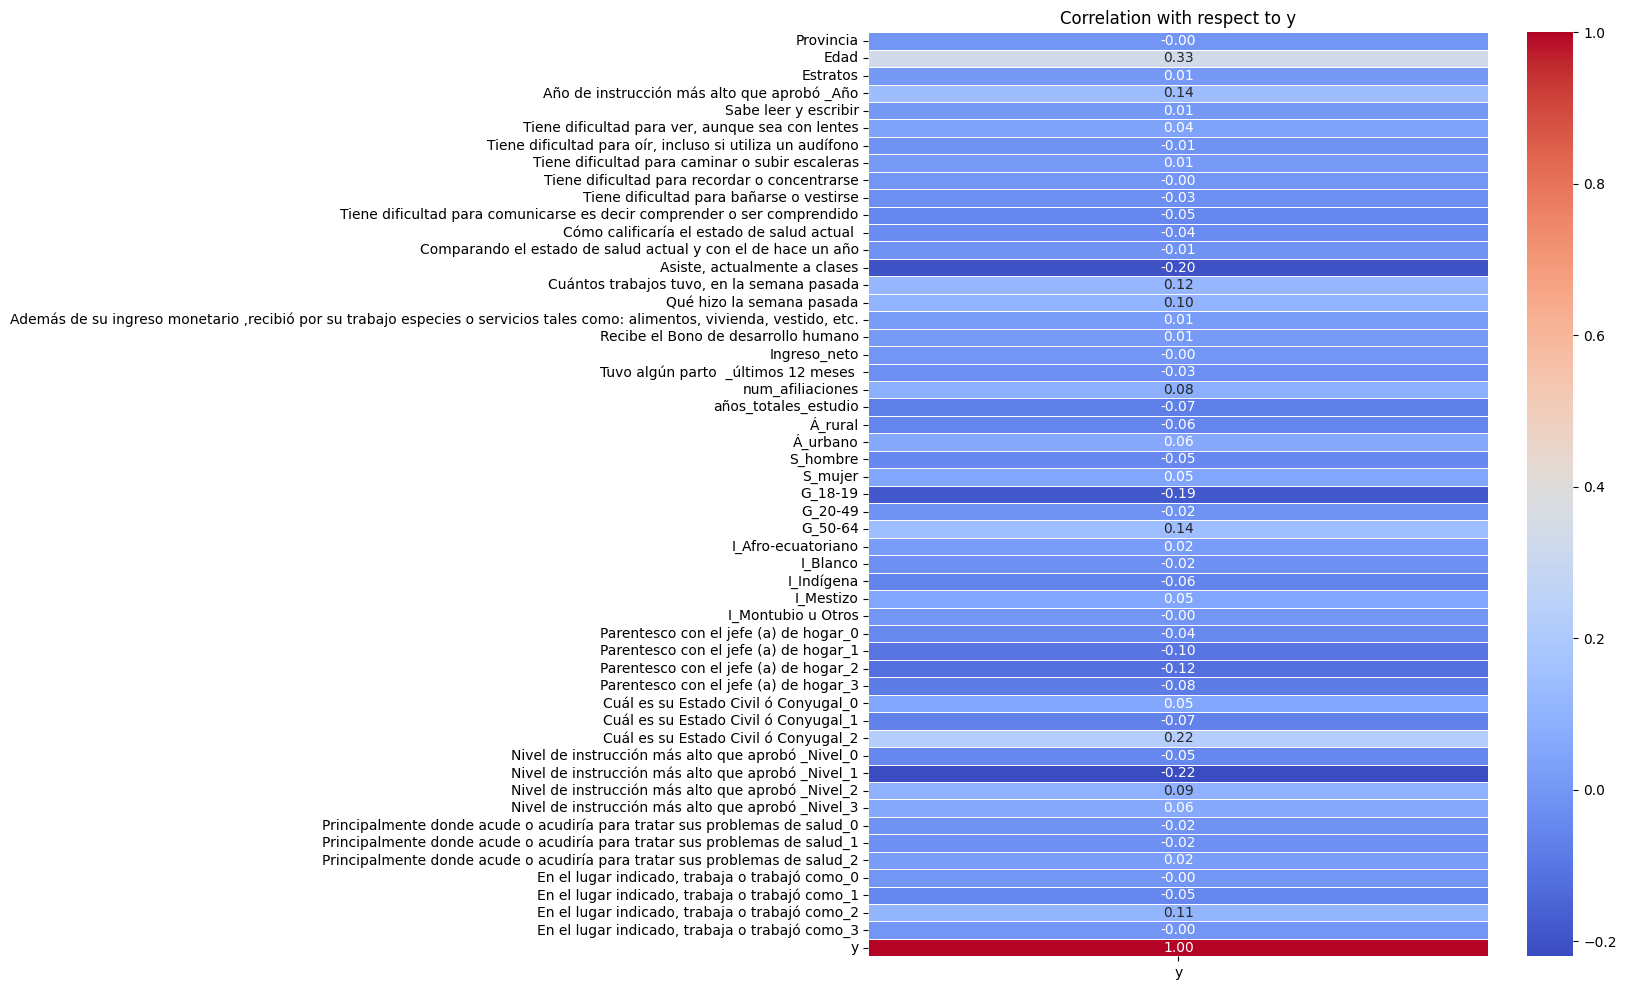

In [ ]:
#Using smote variable with respect to target column
correlation_matrix = X.assign(y=y).corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 12))

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix[['y']], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Customize plot
plt.title('Correlation with respect to y')
plt.show()

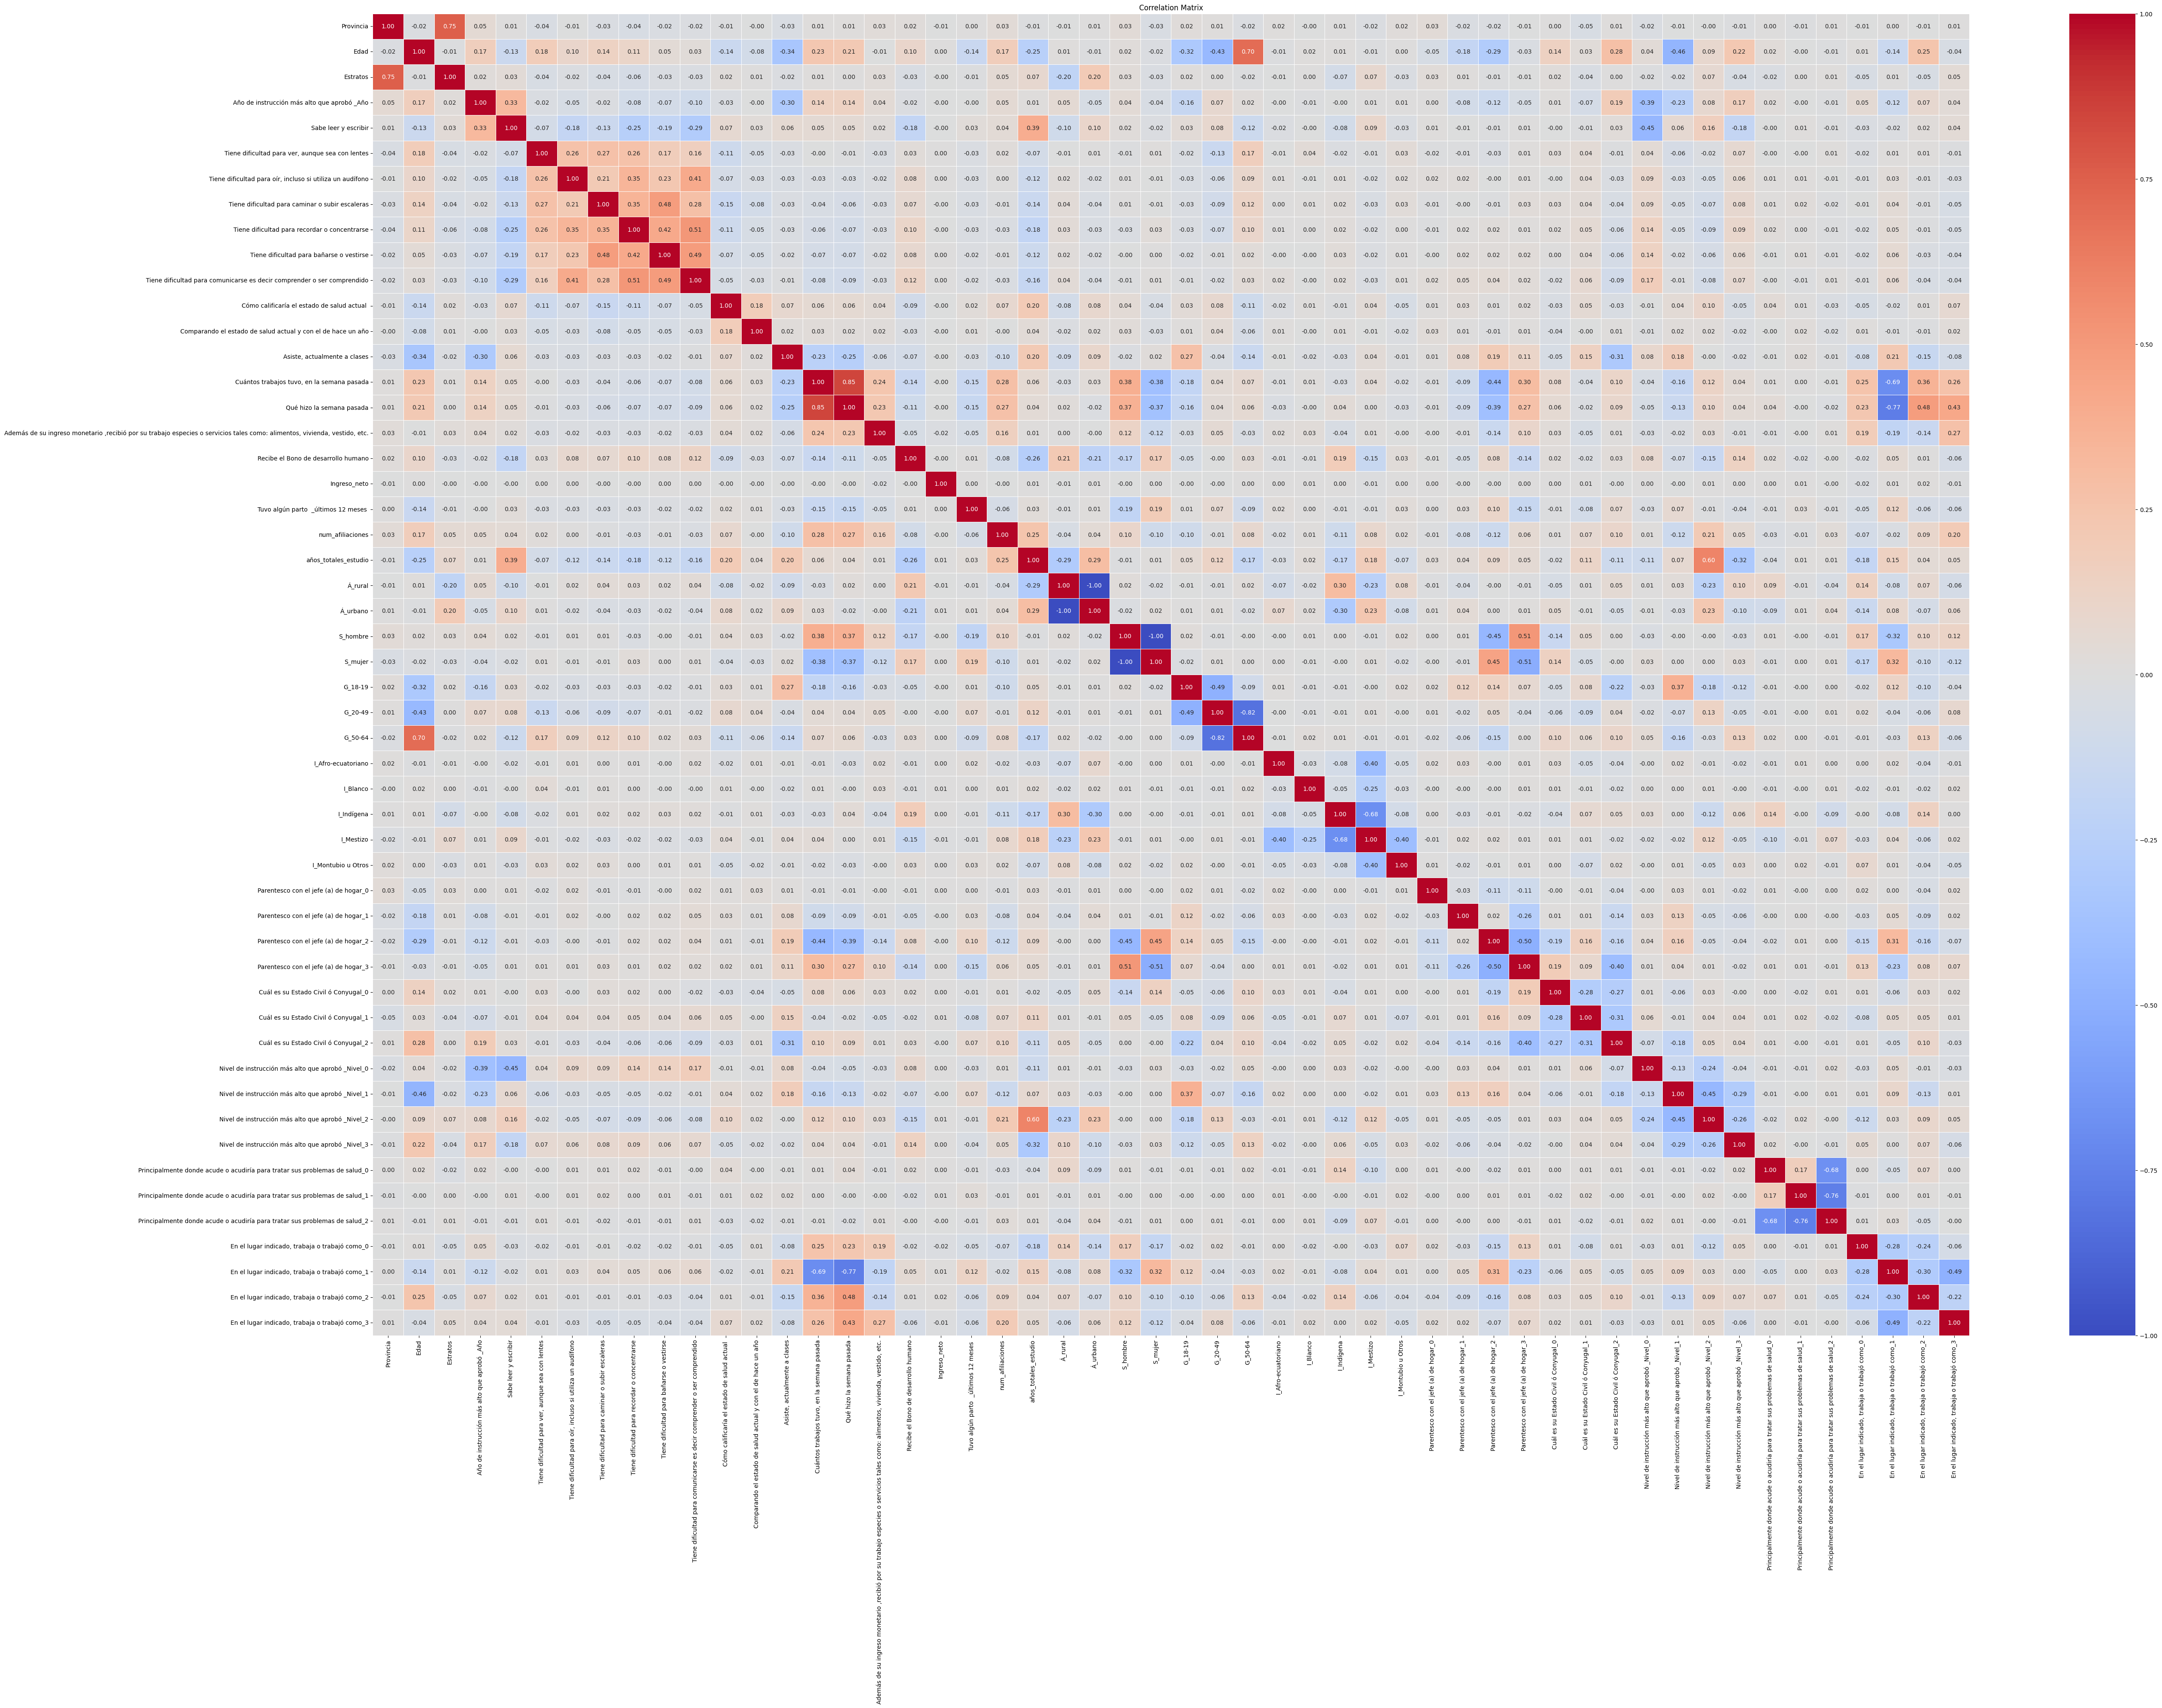

In [ ]:
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(60, 40))

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Customize plot
plt.title('Correlation Matrix')
plt.show()

### **Escalado**

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler=RobustScaler()
X_scaled=scaler.fit_transform(X)

X_ub_scaled = scaler.fit_transform(X_ub)

### **Selección de características**

In [ ]:
mi_score = mutual_info_regression(X_scaled,y)
print(mi_score)

[0.01597724 0.07974857 0.04050204 0.02046222 0.         0.
 0.         0.00021301 0.00171411 0.00280835 0.         0.00053668
 0.00335078 0.0220506  0.01406897 0.01195074 0.         0.
 0.09026898 0.00057853 0.00556629 0.02019922 0.00412626 0.00444537
 0.01154292 0.0021042  0.02271063 0.00168429 0.01074631 0.00212151
 0.00229115 0.00385982 0.00358393 0.00213303 0.0001633  0.00478195
 0.01354786 0.00230254 0.         0.00125335 0.0264311  0.00274643
 0.0295463  0.00240611 0.00171959 0.00137715 0.         0.0016
 0.00163648 0.0038908  0.00764852 0.00151088]


In [ ]:
mi_score_selected_index = np.where(mi_score >0.001)[0]
print("Indices:")
print(mi_score_selected_index)
print("Cantidad de columnas:")
print(mi_score_selected_index.shape[0])
X_IM = X_scaled[:,mi_score_selected_index]

Indices:
[ 0  1  2  3  8  9 12 13 14 15 18 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 35 36 37 39 40 41 42 43 44 45 47 48 49 50 51]
Cantidad de columnas:
40


In [ ]:
y=np.reshape(y, (y.shape[0],1))

In [ ]:
#Dataframe original: df
#Dataframe balanceado: df_balanced
#Matriz de características original (A partir del balanceado): X
#Matriz de características escalado: X_scaled
#Matriz de caracterísitcas escalado despues de feature selection: X_IM

# **Machine Learning**

In [ ]:
X.head()

## **Decision Tree**

###**Sin oversampling**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dividir el dataset en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)

# Inicializar el modelo de Decision Tree
dt = DecisionTreeClassifier(random_state=0)
dt_params = {'max_depth': np.arange(1, 50, 2), 'min_samples_leaf': np.arange(2, 15)}

# Usar GridSearchCV para encontrar los mejores parámetros
gs_dt = GridSearchCV(dt, dt_params, cv=3)
gs_dt.fit(x_train, y_train)
best_params = gs_dt.best_params_

# Entrenar con los mejores parámetros
dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])
model = dtc.fit(x_train, y_train)  # Entrenar el modelo con los datos de entrenamiento
y_pred = model.predict(x_test)  # Hacer predicciones sobre los datos de prueba

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)


###**Decision tree con oversampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Paso 2: Aplicar RandomOverSampler con las características seleccionadas
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Paso 3: Dividir el dataset en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, random_state=2)

# Paso 4: Usar GridSearchCV para encontrar los mejores parámetros
dt = DecisionTreeClassifier(random_state=0)
dt_params = {'max_depth': np.arange(1, 50, 2), 'min_samples_leaf': np.arange(2, 15)}

gs_dt = GridSearchCV(dt, dt_params, cv=3)
gs_dt.fit(x_train, y_train)
best_params = gs_dt.best_params_

# Entrenar con los mejores parámetros
dtc = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])
model = dtc.fit(x_train, y_train)  # Entrenar el modelo con los datos de entrenamiento
y_pred = model.predict(x_test)  # Hacer predicciones sobre los datos de prueba

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)

## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Dividir el dataset en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Inicializar el modelo de Random Forest
rf = RandomForestClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Usar GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train_resampled, y_train_resampled)

# Obtener los mejores parámetros
best_params = grid_search.best_params_

# Entrenar con los mejores parámetros
rf_best = RandomForestClassifier(**best_params, random_state=0)
rf_best.fit(x_train_resampled, y_train_resampled)

# Hacer predicciones sobre los datos de prueba
y_pred = rf_best.predict(x_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)


# **Clustering**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
df_clustering = df.copy()
df_clustering_balanced = df_balanced.copy()
X_IM_clustering = X_IM.copy()
y_clustering = y.copy()

In [ ]:
df_clustering.head(5)

In [ ]:
df_clustering.dtypes

In [ ]:

custom_palette = sns.color_palette("Blues", n_colors=4)

sns.palplot(custom_palette)

# Mostrar el gráfico
plt.show()

## Desbalanceado

In [ ]:
X = np.array(df_clustering[df_clustering.columns[:-1]])
y = np.array(df_clustering['weight_category'])
X.shape

X_scaler = MinMaxScaler().fit_transform(X)
X_scaler.shape

In [ ]:
## Algoritmo KMeans para decidir el número de clúster óptimo, KMeans++ usando el método Elbow M
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X_scaler)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title("KMeans++ usando el Método Elbow")
plt.xlabel("Número of Clusteres")
plt.ylabel("WCSS")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
# Lista para almacenar los valores de la puntuación silhouette
silhouette_scores = []

# Rango de número de clusters
num_clusters_range = range(2, 11)

# Calcular la puntuación silhouette para cada número de clusters
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
    kmeans.fit(X_scaler)
    cluster_labels = kmeans.predict(X_scaler)
    silhouette_avg = silhouette_score(X_scaler, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el resultado
plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("KMeans++ using Elbow Method")
plt.xlabel("Number of Clústers")
plt.ylabel("Silhouette Score")
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

In [ ]:

#Reducción de dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaler)
df_clustering['PCA1'] = pca_result[:, 0]
df_clustering['PCA2'] = pca_result[:, 1]

In [ ]:
# Cree una instancia de KMeans
kmeans = KMeans(n_clusters=4)
#kmeans = KMeans(n_clusters=3,init='k-means++', random_state=0)

# Usa fit_predict para agrupar el conjunto de datos
clusters_pca = kmeans.fit_predict(pca_result)

#Agregar los resultados de los clusters al dataframe origianl
df_clustering['Cluster_PCA'] = clusters_pca
labels = kmeans.labels_



In [ ]:
df_clustering['Cluster_PCA'].value_counts()

In [ ]:
centers = kmeans.cluster_centers_
print(centers)

In [ ]:
custom_palette = sns.color_palette("Blues", n_colors=4)

# Visualización de los clusters en el espacio reducido
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_PCA', palette=custom_palette, data=df_clustering, s=50)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], marker='X', color='red', s=50)
plt.title('Scatter plot de Clústeres (Reducción PCA)')
plt.xlabel('Principal Componente 1')
plt.ylabel('Principal Componente 2')
plt.legend(title='Clústeres')
plt.show()

In [ ]:
df_clustering.groupby('weight_category')['Cluster_PCA'].value_counts()

In [ ]:


sns.countplot(x='weight_category', hue='Cluster_PCA', data=df_clustering, palette=custom_palette)
plt.title("Clústeres de Personas según su categoría de peso")
plt.xlabel("Categoría de peso")
plt.ylabel("Personas")
plt.show()



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crea una tabla cross-tabulation
cross_tab = pd.crosstab(df_clustering['weight_category'], df_clustering['Cluster_PCA'])
print(cross_tab)

# Crear matriz de confusion
confusion_matrix = pd.DataFrame(cross_tab.values, index=cross_tab.index, columns=cross_tab.columns)

# Trazar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Cluster')
plt.ylabel('Categoría de Peso')
plt.show()

# Trazar un gráfico de barras para comparar la distribución de las categorías de peso dentro de cada grupo
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster_PCA', hue='weight_category', data=df_clustering, palette=custom_palette)
plt.title('Comparación de la Categoría de peso dentro de los Clústeres')
plt.xlabel('Cluster')
plt.ylabel('Cuenta')
plt.legend(title='Categoría de peso')
plt.show()


In [ ]:

# Agrupe los datos por la columna 'Clúster' y calcule las características dominantes
cluster_characteristics = df_clustering.groupby('Cluster_PCA').agg(lambda x: x.value_counts().index[0])

# Crear un nuevo DataFrame para almacenar la tabla de características dominantes
dominant_characteristics_df = pd.DataFrame(cluster_characteristics)

# Restablecer el índice para convertir las etiquetas del clúster en una columna normal
dominant_characteristics_df.reset_index(inplace=True)
dominant_characteristics_df

In [ ]:
# Lista de variables para las cuales deseas calcular las estadísticas
variables = ['Edad', 'Ingreso_neto','Cuántos trabajos tuvo, en la semana pasada']

# Agrupar los datos por el cluster y calcular las estadísticas para cada variable
cluster_stats = df_clustering.groupby('Cluster_PCA')[variables].agg(['max', 'min', 'std', 'mean'])
cluster_stats

In [ ]:
cluster_stats.style.background_gradient(cmap='PuBuGn')

## Balanceado

In [ ]:
df_clustering_balanced.head(5)

In [ ]:
X_balanced = np.array(df_clustering_balanced[df_clustering_balanced.columns[:-1]])
y_balanced = np.array(df_clustering_balanced['weight_category'])
X.shape

X_scaler_balanced = MinMaxScaler().fit_transform(X_balanced)
X_scaler_balanced.shape

In [ ]:
from sklearn.decomposition import PCA

#Reducción de dimensionalidad a 2D usando PCA
pca_balanced = PCA(n_components=2)
pca_result_balanced = pca.fit_transform(X_scaler_balanced)
df_clustering_balanced['PCA1'] = pca_result_balanced[:, 0]
df_clustering_balanced['PCA2'] = pca_result_balanced[:, 1]


In [ ]:
custom_palette = sns.color_palette("Blues", n_colors=4)

# Create an instance of KMeans to find
kmeans_balanced = KMeans(n_clusters=4)
#kmeans = KMeans(n_clusters=3,init='k-means++', random_state=0)

# use fit_predict to cluster the dataset
clusters_pca_balanced = kmeans_balanced.fit_predict(pca_result_balanced)

#Agregar los resultados de los clusters al dataframe origianl
df_clustering_balanced['Cluster_PCA_balanced'] = clusters_pca_balanced
labels = kmeans.labels_

In [ ]:
centers = kmeans_balanced.cluster_centers_
print(centers)

In [ ]:
# Visualización de los clusters en el espacio reducido
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_PCA_balanced', palette=custom_palette, data=df_clustering_balanced, s=50)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], marker='X', color='red', s=50)
plt.title('Scatter plot de Clústeres (Reducción PCA)')
plt.xlabel('Principal Componente 1')
plt.ylabel('Principal Componente 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
df_clustering_balanced['Cluster_PCA_balanced'].value_counts()

In [ ]:
df_clustering_balanced.groupby('weight_category')['Cluster_PCA_balanced'].value_counts()

In [ ]:

sns.countplot(x='weight_category', hue='Cluster_PCA_balanced', data=df_clustering_balanced, palette=custom_palette)
plt.title("Clusters de Personas según su categoría de peso")
plt.xlabel("Categoría de peso")
plt.ylabel("Count")
plt.show()



In [ ]:

# Crear una tabla cross-tabulation
cross_tab = pd.crosstab(df_clustering_balanced['weight_category'], df_clustering_balanced['Cluster_PCA_balanced'])
print(cross_tab)

# Crear matriz de confusion
confusion_matrix = pd.DataFrame(cross_tab.values, index=cross_tab.index, columns=cross_tab.columns)

# Trazar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Cluster')
plt.ylabel('Categoría de peso')
plt.show()

# Trazar un gráfico de barras para comparar la distribución de las categorías de peso dentro de cada grupo
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster_PCA_balanced', hue='weight_category', data=df_clustering_balanced, palette=custom_palette)
plt.title('Comparación de la Categoría de peso dentro de los Clústeres')
plt.xlabel('Cluster')
plt.ylabel('Cuenta')
plt.legend(title='Categoría de peso')
plt.show()


In [ ]:
# Agrupe los datos por la columna 'Clúster' y calcule las características dominantes
cluster_characteristics_balanced = df_clustering_balanced.groupby('Cluster_PCA_balanced').agg(lambda x: x.value_counts().index[0])

# Crear un nuevo DataFrame para almacenar la tabla de características dominantes
dominant_characteristics_balanced_df = pd.DataFrame(cluster_characteristics_balanced)

# Restablecer el índice para convertir las etiquetas del clúster en una columna normal
dominant_characteristics_balanced_df.reset_index(inplace=True)
dominant_characteristics_balanced_df

In [ ]:
# Lista de variables para las cuales deseas calcular las estadísticas
variables = ['Edad', 'Ingreso_neto','Cuántos trabajos tuvo, en la semana pasada']

# Agrupar los datos por el cluster y calcular las estadísticas para cada variable
cluster_balanced_stats = df_clustering_balanced.groupby('Cluster_PCA_balanced')[variables].agg(['max', 'min', 'std', 'mean'])
cluster_balanced_stats

In [ ]:
cluster_balanced_stats.style.background_gradient(cmap='PuBuGn')

## DBSCAN

In [ ]:
df_clustering_dbscan_balanced = df_balanced.copy()

In [ ]:
X_dbscan_balanced = np.array(df_clustering_dbscan_balanced[df_clustering_dbscan_balanced.columns[:-1]])
y_dbscan_balanced = np.array(df_clustering_dbscan_balanced['weight_category'])
X_dbscan_balanced.shape

# X_scaler_dbscan_balanced = MinMaxScaler().fit_transform(X_dbscan_balanced)
# X_scaler_dbscan_balanced.shape

In [ ]:
pca = PCA(n_components=2)
pca_result_dbscan = pca.fit_transform(X_dbscan_balanced)
df_clustering_dbscan_balanced['PCA1'] = pca_result_dbscan[:, 0]
df_clustering_dbscan_balanced['PCA2'] = pca_result_dbscan[:, 1]

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=700)
clusters_dbscan = dbscan.fit_predict(pca_result_dbscan) #df_clustering

#Agregar los resultados de los clusters al dataframe origianl
df_clustering_dbscan_balanced['Cluster_DBSCAN'] = clusters_dbscan

np.unique(clusters_dbscan)
#-1 is noise

In [ ]:
custom_palette = sns.color_palette("Blues", n_colors=7)

# Visualización de los clusters en el espacio reducido
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_DBSCAN', palette=custom_palette, data=df_clustering_dbscan_balanced, s=50)
plt.title('Scatter plot de Clústeres (Reducción PCA)')
plt.xlabel('Principal Componente 1')
plt.ylabel('Principal Componente 2')

plt.legend(title='Cluster')
plt.show()

In [ ]:
df_clustering_dbscan_balanced['Cluster_DBSCAN'].value_counts()

In [ ]:

# Crear una tabla cross-tabulation
cross_tab = pd.crosstab(df_clustering_dbscan_balanced['weight_category'], df_clustering_dbscan_balanced['Cluster_DBSCAN'])
print(cross_tab)

# Crear matriz de confusion
confusion_matrix = pd.DataFrame(cross_tab.values, index=cross_tab.index, columns=cross_tab.columns)

# Trazar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Cluster')
plt.ylabel('Categoría de peso')
plt.show()

# Trazar un gráfico de barras para comparar la distribución de las categorías de peso dentro de cada grupo
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster_DBSCAN', hue='weight_category', data=df_clustering_dbscan_balanced, palette=custom_palette)
plt.title('Comparación de la Categoría de peso dentro de los Clústeres')
plt.xlabel('Cluster')
plt.ylabel('Cuenta')
plt.legend(title='Categoría de peso')
plt.show()


In [ ]:
# Agrupe los datos por la columna 'Clúster' y calcule las características dominantes
cluster_characteristics_dbscan_balanced = df_clustering_dbscan_balanced.groupby('Cluster_DBSCAN').agg(lambda x: x.value_counts().index[0])

# Crear un nuevo DataFrame para almacenar la tabla de características dominantes
dominant_characteristics_dbscan_balanced_df = pd.DataFrame(cluster_characteristics_dbscan_balanced)

# Restablecer el índice para convertir las etiquetas del clúster en una columna normal
dominant_characteristics_dbscan_balanced_df.reset_index(inplace=True)
dominant_characteristics_dbscan_balanced_df

In [ ]:
# Lista de variables para las cuales deseas calcular las estadísticas
variables = ['Edad', 'Ingreso_neto','Cuántos trabajos tuvo, en la semana pasada']

# Agrupar los datos por el cluster y calcular las estadísticas para cada variable
cluster_balanced_dbscan_stats = df_clustering_dbscan_balanced.groupby('Cluster_DBSCAN')[variables].agg(['max', 'min', 'std', 'mean'])
cluster_balanced_dbscan_stats

# **MLP**

### **Definicón de la red**

In [ ]:
class CSVDataset(Dataset):

    def __init__(self, data):
        # cargar el archivo csv como un marco de datos
        self.X = data[0].astype('float32')
        self.y = data[1].astype('int64').reshape(-1)

    # número de filas del conjunto de datos
    def __len__(self):
        return len(self.X)

    # obtener una fila en un índice
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determinar los tamaños
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calcular la división
        return random_split(self, [train_size, test_size])

def prepare_data(data):
    # Existing code to load the dataset
    dataset = CSVDataset(data)
    train, test = dataset.get_splits()
    val_size = int(0.1 * len(train))  # 10% for validation
    train_size = len(train) - val_size
    train, val = random_split(train, [train_size, val_size])

    # Update DataLoader creation
    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    val_dl = DataLoader(val, batch_size=64, shuffle=False)
    test_dl = DataLoader(test, batch_size=64, shuffle=False)
    return train_dl, val_dl, test_dl

def evaluate_model(test_dl, model):
    list_categories = ['Bajo peso en adultos de 19 a 59 años', 'Peso Normal en adultos de 19 a 59 años', 'Sobrepeso en adultos de 19 a 59 años ', 'Obesidad en adultos de 19 a 59 años ']
    model.eval()
    predictions, actuals = list(), list()
    with torch.no_grad():
      for inputs, targets in test_dl:
          # evaluar el modelo en el conjunto de pruebas
          yhat = model(inputs)
          # se recupera el indice cuyo valor es mas alto entre las salidas del modelo
          yhat = yhat.argmax(dim=1).tolist()
          actual = targets.tolist()
          predictions.extend(yhat)
          actuals.extend(actual)
    #Se calcula la precision del modelo
    accuracy = accuracy_score(actuals, predictions)
    print("Details:")
    print(metrics.classification_report(actuals, predictions))
    cm = metrics.confusion_matrix(actuals, predictions)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
    ax.set(xlabel="Reales", ylabel="Verdaderos", xticklabels=list_categories,yticklabels=list_categories, title="Matriz de confusión")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)

    plt.show()

    return accuracy

def predict(row, model):
  row = torch.Tensor(row)
  with torch.no_grad():
    y_pred = model(row)
    predictions = y_pred.argmax(dim=1).tolist()
  return predictions

class MLP(Module):
    def __init__(self, n_inputs, n_output, n_layer_1, n_layer_2, n_layer_3, n_layer_4, n_layer_5):
        super(MLP, self).__init__()

        self.hidden1 = Linear(n_inputs, n_layer_1)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = ReLU()
        self.drop1 = Dropout(p=0.05)

        self.hidden2 = Linear(n_layer_1, n_layer_2)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = LeakyReLU(negative_slope=0.01)
        self.drop2 = Dropout(p=0.05)

        self.hidden3 = Linear(n_layer_2, n_layer_3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = LeakyReLU(negative_slope=0.01)
        self.drop3 = Dropout(p=0.05)

        self.hidden4 = Linear(n_layer_3, n_layer_4)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = LeakyReLU(negative_slope=0.01)
        self.drop4 = Dropout(p=0.05)

        self.hidden5 = Linear(n_layer_4, n_layer_5)
        xavier_uniform_(self.hidden5.weight)
        self.act5 = Tanh()
        self.drop5 = Dropout(p=0.05)

        self.output = Linear(n_layer_5, n_output)
        xavier_uniform_(self.output.weight)
        self.act6 = nn.LogSoftmax(dim=1)

    def forward(self, X):
        # Entrada a la primer capa
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.drop1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.drop2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.drop3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        X = self.drop4(X)
        X = self.hidden5(X)
        X = self.act5(X)
        X = self.drop5(X)
        X = self.output(X)
        X = self.act6(X)
        return X

from torch.optim.lr_scheduler import StepLR

def train_model(train_dl, val_dl, model):
    # Se definen los parametros de optimizacion
    criterion = NLLLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    # Ensure the directory for saving models exists
    model_save_path = 'best_model.pth'

    torch.save(model.state_dict(), model_save_path)

    min_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    val_losses = []
    precisions = []

    # se recoren las epocas de entrenamiento
    for epoch in range(100):
        model.train()
        for i, (inputs, targets) in enumerate(train_dl):
            # Borran gradientes
            optimizer.zero_grad()
            yhat = model(inputs)
            # Se calcula la perdida
            loss = criterion(yhat, targets)
            loss.backward()
            # Se actualizan los pesos
            optimizer.step()

        val_loss, precision = validate_model(val_dl, model)
        val_losses.append(val_loss)
        precisions.append(precision)
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss}, Precision: {precision}')

        # Check for Early Stopping
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0  # reset counter if validation loss improves
            torch.save(model.state_dict(), model_save_path)  # save the best model
        else:
            patience_counter += 1  # increment counter if no improvement
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

        scheduler.step()

    model.load_state_dict(torch.load(model_save_path))  # load the best model
    plot_metrics(val_losses, precisions)
    return model

def validate_model(val_dl, model):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = NLLLoss()
    with torch.no_grad():
        for inputs, targets in val_dl:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Calculate precision
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(val_dl)
    precision = correct / total
    return avg_loss, precision

def plot_metrics(val_losses, precisions):
    epochs = range(1, len(val_losses) + 1)

    min_val_loss_epoch = val_losses.index(min(val_losses)) + 1

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_losses, label='Pérdida de Validación')
    plt.axvline(min_val_loss_epoch, color='green', linestyle='--', label='Mínima Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida de Validación durante entrenamiento')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, precisions, label='Precisión')
    plt.axvline(min_val_loss_epoch, color='green', linestyle='--', label='Mínima Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Precisión durante entrenamiento')
    plt.legend()

    plt.show()

### **Entrenamiento con dataframe balanceado**

In [ ]:
train_dl, val_dl, test_dl = prepare_data((X_scaled, y))
print(f'Cantidad de datos de entrenamiento: {len(train_dl.dataset)}')
print(f'Cantidad de datos de prueba: {len(test_dl.dataset)}')

Cantidad de datos de entrenamiento: 73957
Cantidad de datos de prueba: 40474


Epoch 1, Validation Loss: 1.1205665002497591, Precision: 0.47718145308506754
Epoch 2, Validation Loss: 0.9543310935183089, Precision: 0.5443592552026287
Epoch 3, Validation Loss: 0.8805365174315697, Precision: 0.5734452963368626
Epoch 4, Validation Loss: 0.8521420572155206, Precision: 0.5814774248509188
Epoch 5, Validation Loss: 0.8419486187225165, Precision: 0.5863453815261044
Epoch 6, Validation Loss: 0.8268223908520484, Precision: 0.5909699403675307
Epoch 7, Validation Loss: 0.8364265223806219, Precision: 0.5988803699647073
Epoch 8, Validation Loss: 0.8223255345987719, Precision: 0.5979067786296702
Epoch 9, Validation Loss: 0.8150168481723282, Precision: 0.6038700255567725
Epoch 10, Validation Loss: 0.796434643194657, Precision: 0.6162833150784958
Epoch 11, Validation Loss: 0.7914965702581775, Precision: 0.6237069490081538
Epoch 12, Validation Loss: 0.7861199203387711, Precision: 0.6261409273457467
Epoch 13, Validation Loss: 0.7829601247181264, Precision: 0.6330777656078861
Epoch 14

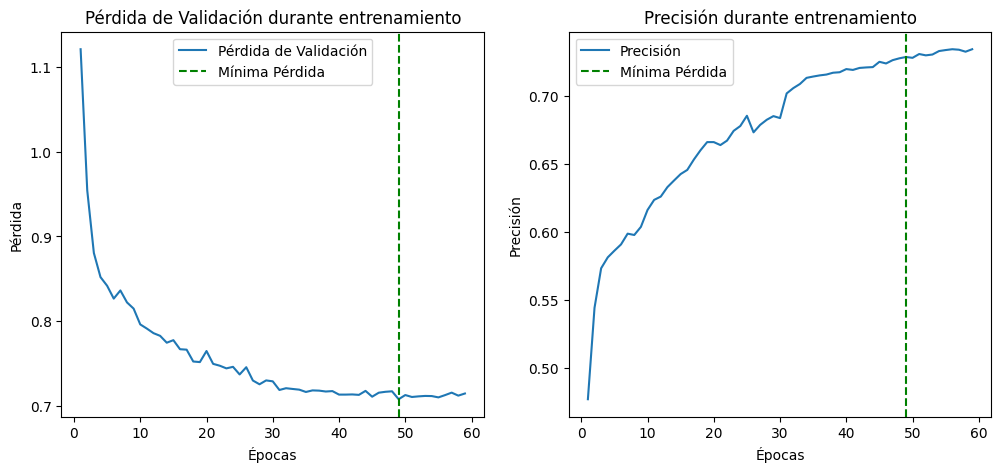

In [ ]:
torch.manual_seed(101)
np.random.seed(101)
random.seed(101)

# Ensure deterministic behavior for certain operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Se definen los parametros del modelo, el cual tendra una capa oculta de 10 neuronas
n_inputs = X_scaled.shape[1]
n_layer_1 = 120
n_layer_2 = 300
n_layer_3 = 150
n_layer_4 = 80
n_layer_5 = 30
n_output = 4

#Se define el modelo
model = MLP(n_inputs, n_output, n_layer_1, n_layer_2, n_layer_3, n_layer_4, n_layer_5)

# Entrenamiento del modelo
model = train_model(train_dl, val_dl, model)

Details:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10048
           1       0.67      0.62      0.64     10205
           2       0.61      0.57      0.59     10278
           3       0.68      0.73      0.70      9943

    accuracy                           0.73     40474
   macro avg       0.73      0.73      0.73     40474
weighted avg       0.73      0.73      0.73     40474



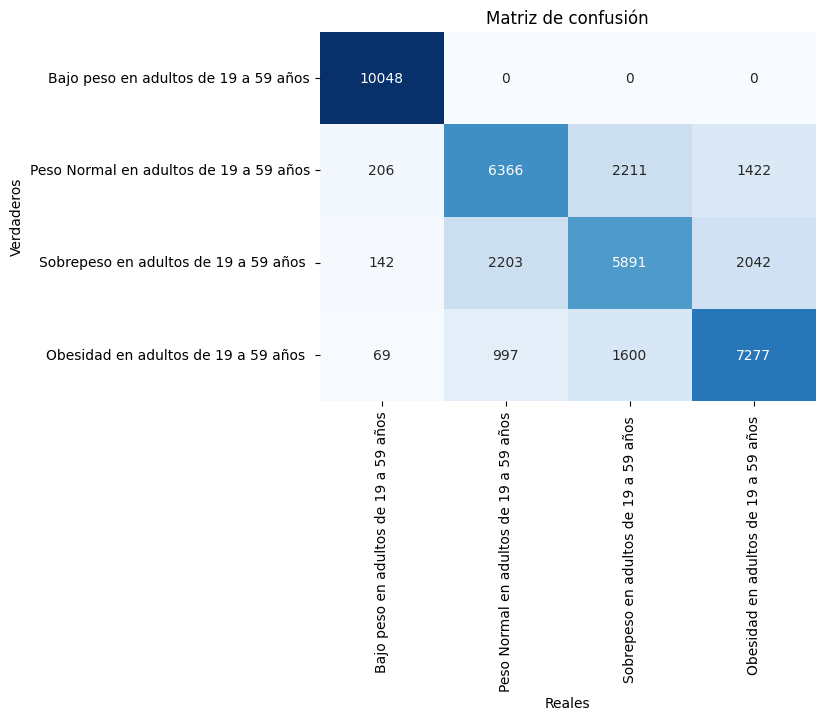

Accuracy: 73.089 %


In [ ]:
# Se evalua el modelo usando MSE
acc= evaluate_model(test_dl, model)
print('Accuracy: %.3f' % (acc *100), "%")

In [ ]:
df.shape


(74786, 53)

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize counters
matches = 0
total_samples = 100  # Number of random samples to test

# Get the total number of batches in the test DataLoader
num_batches = len(test_dl)

for i in range(total_samples):
    # Randomly select a batch
    batch_idx = random.randint(0, num_batches - 1)

    # Get the batch from the DataLoader
    for batch_num, (inputs, targets) in enumerate(test_dl):
        if batch_num == batch_idx:
            break

    # Randomly select a sample from the batch
    sample_idx = random.randint(0, len(targets) - 1)
    row_tensor = inputs[sample_idx].unsqueeze(0)  # Unsqueeze to add batch dimension
    real = targets[sample_idx].item()

    # Make a prediction
    with torch.no_grad():
        yhat = model(row_tensor)
        yhat = yhat.argmax(dim=1).item()

    # Compare predicted and real values
    if yhat == real:
        matches += 1

print(f'Matches: {matches} de 100')

Matches: 79 de 100


### **Entrenamiento con dataframe sin balancear**

In [ ]:
train_dl_ub, val_dl_ub, test_dl_ub = prepare_data((X_ub_scaled, y_ub))
print(f'Cantidad de datos de entrenamiento: {len(train_dl_ub.dataset)}')
print(f'Cantidad de datos de prueba: {len(test_dl_ub.dataset)}')

Cantidad de datos de entrenamiento: 45097
Cantidad de datos de prueba: 24679


Epoch 1, Validation Loss: 1.0815345433693897, Precision: 0.46427145708582834
Epoch 2, Validation Loss: 1.0759041045285478, Precision: 0.4692614770459082
Epoch 3, Validation Loss: 1.0773315542860875, Precision: 0.4746506986027944
Epoch 4, Validation Loss: 1.075653698625444, Precision: 0.4654690618762475
Epoch 5, Validation Loss: 1.0826225446749338, Precision: 0.45708582834331335
Epoch 6, Validation Loss: 1.08316847417928, Precision: 0.45868263473053894
Epoch 7, Validation Loss: 1.082940697669983, Precision: 0.4620758483033932
Epoch 8, Validation Loss: 1.0924463151376458, Precision: 0.4612774451097804
Epoch 9, Validation Loss: 1.0953648973114882, Precision: 0.4546906187624751
Epoch 10, Validation Loss: 1.1014277052275743, Precision: 0.45808383233532934
Epoch 11, Validation Loss: 1.1060131365739847, Precision: 0.4487025948103792
Epoch 12, Validation Loss: 1.123061581502987, Precision: 0.4500998003992016
Epoch 13, Validation Loss: 1.1315591237213039, Precision: 0.443313373253493
Epoch 14, 

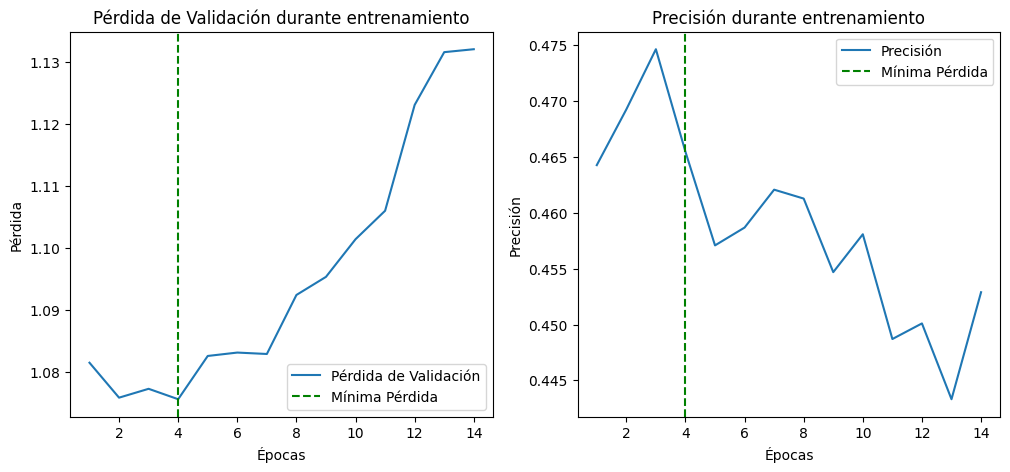

In [ ]:
torch.manual_seed(101)

#Se definen los parametros del modelo, el cual tendra una capa oculta de 10 neuronas
n_inputs = X_ub_scaled.shape[1]
n_layer_1 = 120
n_layer_2 = 300
n_layer_3 = 150
n_layer_4 = 80
n_layer_5 = 30
n_output = 4

#Se define el modelo
model_ub = MLP(n_inputs, n_output, n_layer_1, n_layer_2, n_layer_3, n_layer_4, n_layer_5)

# Entrenamiento del modelo
model_ub = train_model(train_dl_ub, val_dl_ub, model_ub)

Details:
              precision    recall  f1-score   support

           0       0.39      0.69      0.50       310
           1       0.57      0.54      0.55      8780
           2       0.55      0.50      0.52     10141
           3       0.45      0.54      0.49      5448

    accuracy                           0.53     24679
   macro avg       0.49      0.57      0.52     24679
weighted avg       0.53      0.53      0.53     24679



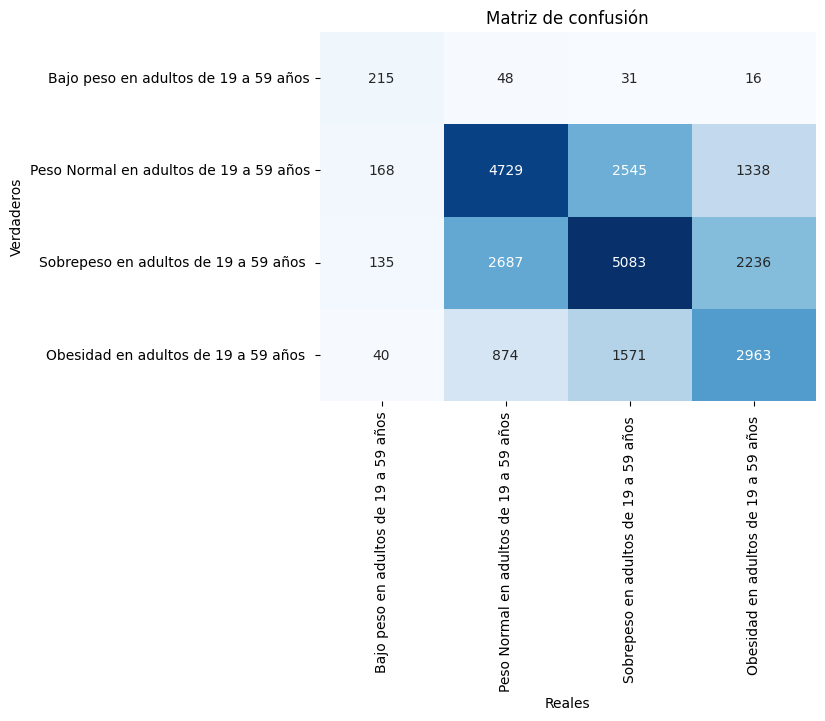

Accuracy: 52.636 %


In [ ]:
# Se evalua el modelo usando MSE
acc= evaluate_model(test_dl_ub, model)
print('Accuracy: %.3f' % (acc *100), "%")

In [ ]:
# Ensure the model is in evaluation mode
model_ub.eval()

# Initialize counters
matches = 0
total_samples = 100  # Number of random samples to test

# Get the total number of batches in the test DataLoader
num_batches = len(test_dl_ub)

for i in range(total_samples):
    # Randomly select a batch
    batch_idx = random.randint(0, num_batches - 1)

    # Get the batch from the DataLoader
    for batch_num, (inputs, targets) in enumerate(test_dl_ub):
        if batch_num == batch_idx:
            break

    # Randomly select a sample from the batch
    sample_idx = random.randint(0, len(targets) - 1)
    row_tensor = inputs[sample_idx].unsqueeze(0)  # Unsqueeze to add batch dimension
    real = targets[sample_idx].item()

    # Make a prediction
    with torch.no_grad():
        yhat = model_ub(row_tensor)
        yhat = yhat.argmax(dim=1).item()

    # Compare predicted and real values
    if yhat == real:
        matches += 1

print(f'Matches: {matches} de 100')

Matches: 49 de 100
